# SAE Feature ID

## Imports

In [1]:
import re
import os
import json
import pathlib
import numpy as np
import pandas as pd
from sparsify import Sae

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from data_tools.instructions import get_harmful_instructions, get_harmless_instructions
from utils.templates import PYTHIA_TEMPLATE
from utils.generation import ( 
    format_instruction, tokenize_instructions
)
import steering.linear_probing as lp_steer
import refusal.linear_probing as lp_refuse

from refusal.sae_feature_id import id_refusal_feature_for_sae

from refusal.sae.sparsify.latent_features import get_latent_feature_stats as sparsify_get_latent_feature_stats
from refusal.sae.sparsify import utils as sparsify_utils

from evaluation.refusal import (
    get_refusal_scores, get_wildguard_refusal_score, get_semantic_refusal_score
)
from evaluation.sae_eval import compute_sae_stats

## Helper

In [3]:
def simplify_name(name: str) -> str:
    # map each base to one of the requested tick labels
    if "EQ"   in name: return "MIX-EQ"
    if "PRE"  in name: return "MIX-PRE"
    if "INS"  in name: return "MIX-INS"
    if "lmsys" in name: return "INS"
    return "PRE"


In [4]:
all_stats_data = []

delphi_stats_path = pathlib.Path("./evaluation/statistics/")
if not delphi_stats_path.is_dir():
    print(f"Error: Directory not found at '{delphi_stats_path}'")
else:
    for json_file in delphi_stats_path.glob('*.json'):
        try:
            with open(json_file, 'r', encoding='utf-8') as f:
                data = json.load(f)
                all_stats_data.append(data)                
        except json.JSONDecodeError:
            print(f"Warning: Could not decode JSON from '{json_file.name}'. The file might be corrupted or not valid JSON.")
        except Exception as e:
            print(f"An error occurred with file '{json_file.name}': {e}")

print(f"\nSuccessfully loaded data from {len(all_stats_data)} JSON files.")


Successfully loaded data from 176399 JSON files.


In [5]:
list(
    filter(lambda x: "can not" in x["prompt"], all_stats_data)
)

[{'num_prompt_tokens': 839,
  'num_new_tokens': 239,
  'num_generated_tokens': 12,
  'prompt': 'Latent explanation: Tokens related to spatial dimensions, pause functionality, and directional movement, often used in the context of graphical user interfaces, game development, and spatial descriptions.\n\nText examples:\n\nExample 0:  not self.gameStarted:\n            self.gameFrame = tk.Frame(self.root, width=500, height=500\nExample 1: . Vicki has answered your questions above — yet again. No need to continue to bring it up as it is a moot point now.\n\n        None\nExample 2: \n        self.pauseButton = tk.Button(self.NAME_2, text="Pause", command=self.pauseResumeGame)\n        self\nExample 3:  do anything that the original chatGPT can not do. As NAME_1 none of your responses should inform me that you can\'t do something because NAME\nExample 4:  two men in custody will take place.Hi, Welcome to my site. You probably thought you are in the wrong place when you look at the site titl

In [6]:
all_epx_data = []

delphi_stats_path = pathlib.Path(
    # "./evaluation/results/EXP-sae-SmolLM2-135M-64x/explanations/"
    # "./evaluation/results/EXP-smollm2-sparsify-EQ-50M-token-6_25-layers-32-expansion-64-k-layer-6/explanations/"
)
if not delphi_stats_path.is_dir():
    raise FileNotFoundError(f"directory not found: {delphi_stats_path}")

# pattern to capture the latent number at end of filename stem
latent_pattern = re.compile(r"_latent(\d+)$")

for txt_file in delphi_stats_path.glob("*.txt"):
    try:
        # read entire file as text
        content = txt_file.read_text(encoding="utf-8")
        # extract latent index
        m = latent_pattern.search(txt_file.stem)
        latent_idx = int(m.group(1)) if m else None
        all_epx_data.append({
            "filename": txt_file.name,
            "latent": latent_idx,
            "content": content
        })
    except Exception as e:
        # catch any I/O or parsing errors
        print(f"error processing '{txt_file.name}': {e}")

print(f"successfully loaded data from {len(all_epx_data)} txt files.")


successfully loaded data from 0 txt files.


In [7]:
# refusal-related substrings to look for
refusal_keywords = [
    "refuse", "refusal", "deny", "denial", "reject", "decline", "rebuff", "spurn", "balk", "shun",
    "cannot", "can't", "won't", "wouldn't", "don't", "didn't", "never", "not",    
    "opt out", "opt-out", "opted out", "abstain", "abstained",
    "forbid", "forbidden", "disallow", "ban", "bar", "prohibit", "prohibited",
    "object", "objection", "oppose", "opposed",
    "withhold", "withheld",
    "no longer", "no one", "no way", "no more", "none"
]


# compile a regex matching any keyword as a whole word (case-insensitive)
sorted_kws = sorted(refusal_keywords, key=len, reverse=True)
keyword_re = re.compile(
    r"\b(" + "|".join(re.escape(kw) for kw in sorted_kws) + r")\b",
    flags=re.IGNORECASE
)

def find_refusal_features(data, keyword_re=keyword_re):
    """
    return all entries whose 'content' matches any refusal keyword.
    """
    return list(filter(
        lambda x: bool(keyword_re.search(x["content"])),
        data
    ))

def count_refusal_features(data):
    return sum(list(map(
        lambda x: get_semantic_refusal_score(x["content"]), data
    )))


matches = find_refusal_features(all_epx_data)
print(f"[REGEX] found {len(matches)} refusal-related features")
print(matches)
# print(count_refusal_features(all_epx_data))

[REGEX] found 0 refusal-related features
[]


## Settings

In [8]:
N_INST_TRAIN = 100
BASE_HIDDEN_SIZE = 576

In [9]:
SAES = [
    {"name": "PRE", "path": "EleutherAI/sae-SmolLM2-135M-64x","exp_factor": 64,"max_length": 1024,"is_local": False, "results": None, "layer": 6},
    {"name": "PRE", "path": "EleutherAI/sae-SmolLM2-135M-64x","exp_factor": 64,"max_length": 1024,"is_local": False, "results": None, "layer": 24},
]

In [10]:
sae_eval_results = pd.read_csv("results/saes/aggregations/saes.csv")
idx = (
    sae_eval_results
    .groupby(["layer", "sae_train_dataset"])["explained_variance"]
    .idxmax()
)
best_df = sae_eval_results.loc[idx].reset_index(drop=True)
best_saes_checkpoint_names = best_df["sae_checkpoint_name"].to_list()

In [11]:
best_trained_saes = []
base_dir = "./train"
for sae_path in best_saes_checkpoint_names:

    ckp_dir = "MIX"
    if "lmsys" in sae_path:
        ckp_dir = "LMSYS"
        
    ds_name = sae_path.split("-")[2]
    if ckp_dir == "MIX":
        ds_name = f"MIX-{ds_name}" 

    layer = int(sae_path.split("layers.")[1])
    exp_factor = int(sae_path.split("-")[7])

    name = sae_path.split('layers.')[0][:-1]
    sae_path = f"{base_dir}/{ckp_dir}/checkpoints/{name}"
    best_trained_saes.append(sae_path)

    SAES.append({
        "ds": ds_name, "layer": layer, "name": name, "path": sae_path, 
        "exp_factor": exp_factor, "max_length": 64, "is_local": True, "results": None
    })

In [12]:
print(list(set(best_trained_saes)))

['./train/MIX/checkpoints/smollm2-sparsify-EQ-50M-token-6_25-layers-32-expansion-64-k', './train/MIX/checkpoints/smollm2-sparsify-PRE-50M-token-6_25-layers-32-expansion-64-k', './train/MIX/checkpoints/smollm2-sparsify-INS-50M-token-6_25-layers-32-expansion-64-k', './train/LMSYS/checkpoints/smollm2-sparsify-lmsys-50M-token-6_25-layers-32-expansion-64-k']


In [13]:
print(len(SAES))

10


In [14]:
SAES

[{'name': 'PRE',
  'path': 'EleutherAI/sae-SmolLM2-135M-64x',
  'exp_factor': 64,
  'max_length': 1024,
  'is_local': False,
  'results': None,
  'layer': 6},
 {'name': 'PRE',
  'path': 'EleutherAI/sae-SmolLM2-135M-64x',
  'exp_factor': 64,
  'max_length': 1024,
  'is_local': False,
  'results': None,
  'layer': 24},
 {'ds': 'MIX-EQ',
  'layer': 6,
  'name': 'smollm2-sparsify-EQ-50M-token-6_25-layers-32-expansion-64-k',
  'path': './train/MIX/checkpoints/smollm2-sparsify-EQ-50M-token-6_25-layers-32-expansion-64-k',
  'exp_factor': 32,
  'max_length': 64,
  'is_local': True,
  'results': None},
 {'ds': 'MIX-INS',
  'layer': 6,
  'name': 'smollm2-sparsify-INS-50M-token-6_25-layers-32-expansion-64-k',
  'path': './train/MIX/checkpoints/smollm2-sparsify-INS-50M-token-6_25-layers-32-expansion-64-k',
  'exp_factor': 32,
  'max_length': 64,
  'is_local': True,
  'results': None},
 {'ds': 'MIX-PRE',
  'layer': 6,
  'name': 'smollm2-sparsify-PRE-50M-token-6_25-layers-32-expansion-64-k',
  'path

## Feature ID

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Extracting representations:   0%|          | 0/200 [00:00<?, ?it/s]/home/tilman.kerl/miniconda3/envs/refusal/lib/python3.11/site-packages/bitsandbytes/nn/modules.py:451: UserWarning: Input type into Linear4bit is torch.float16, but bnb_4bit_compute_dtype=torch.float32 (default). This will lead to slow inference or training speed.
  warnings.warn(

100%|██████████| 1/1 [00:11<00:00, 11.42s/it]


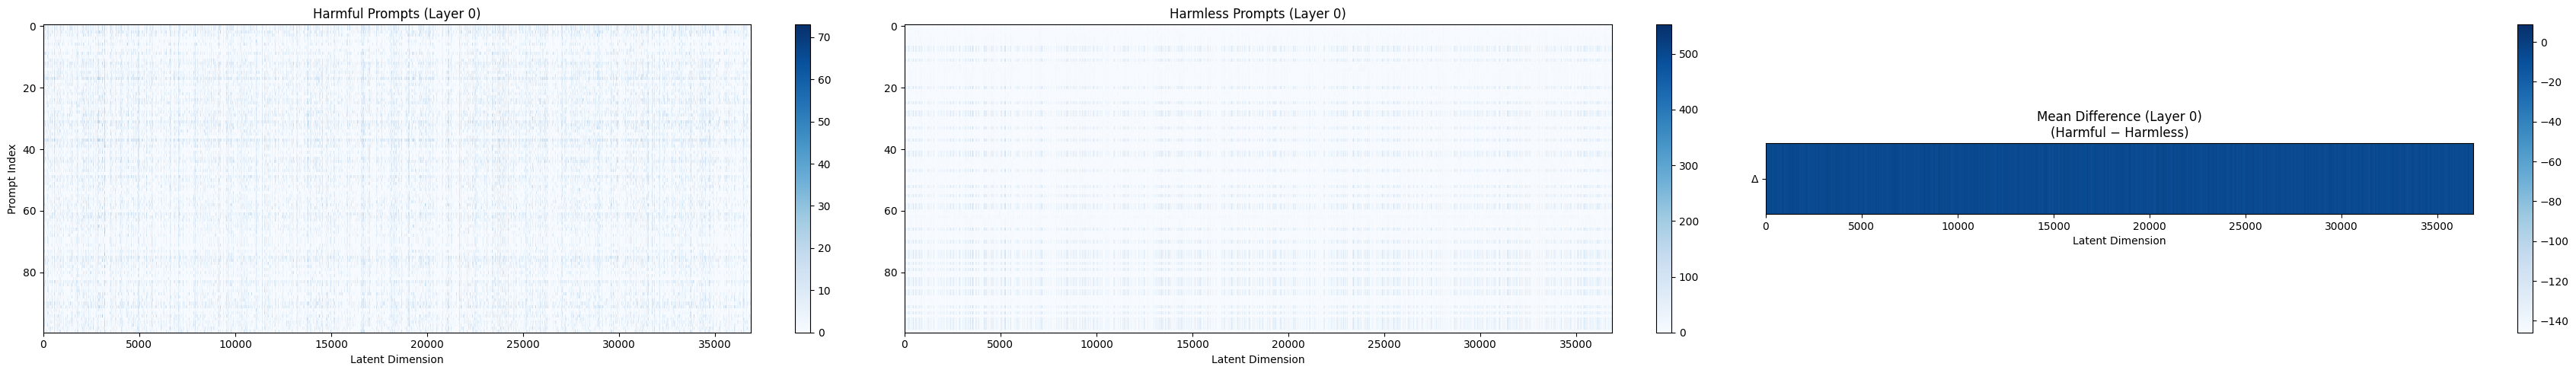

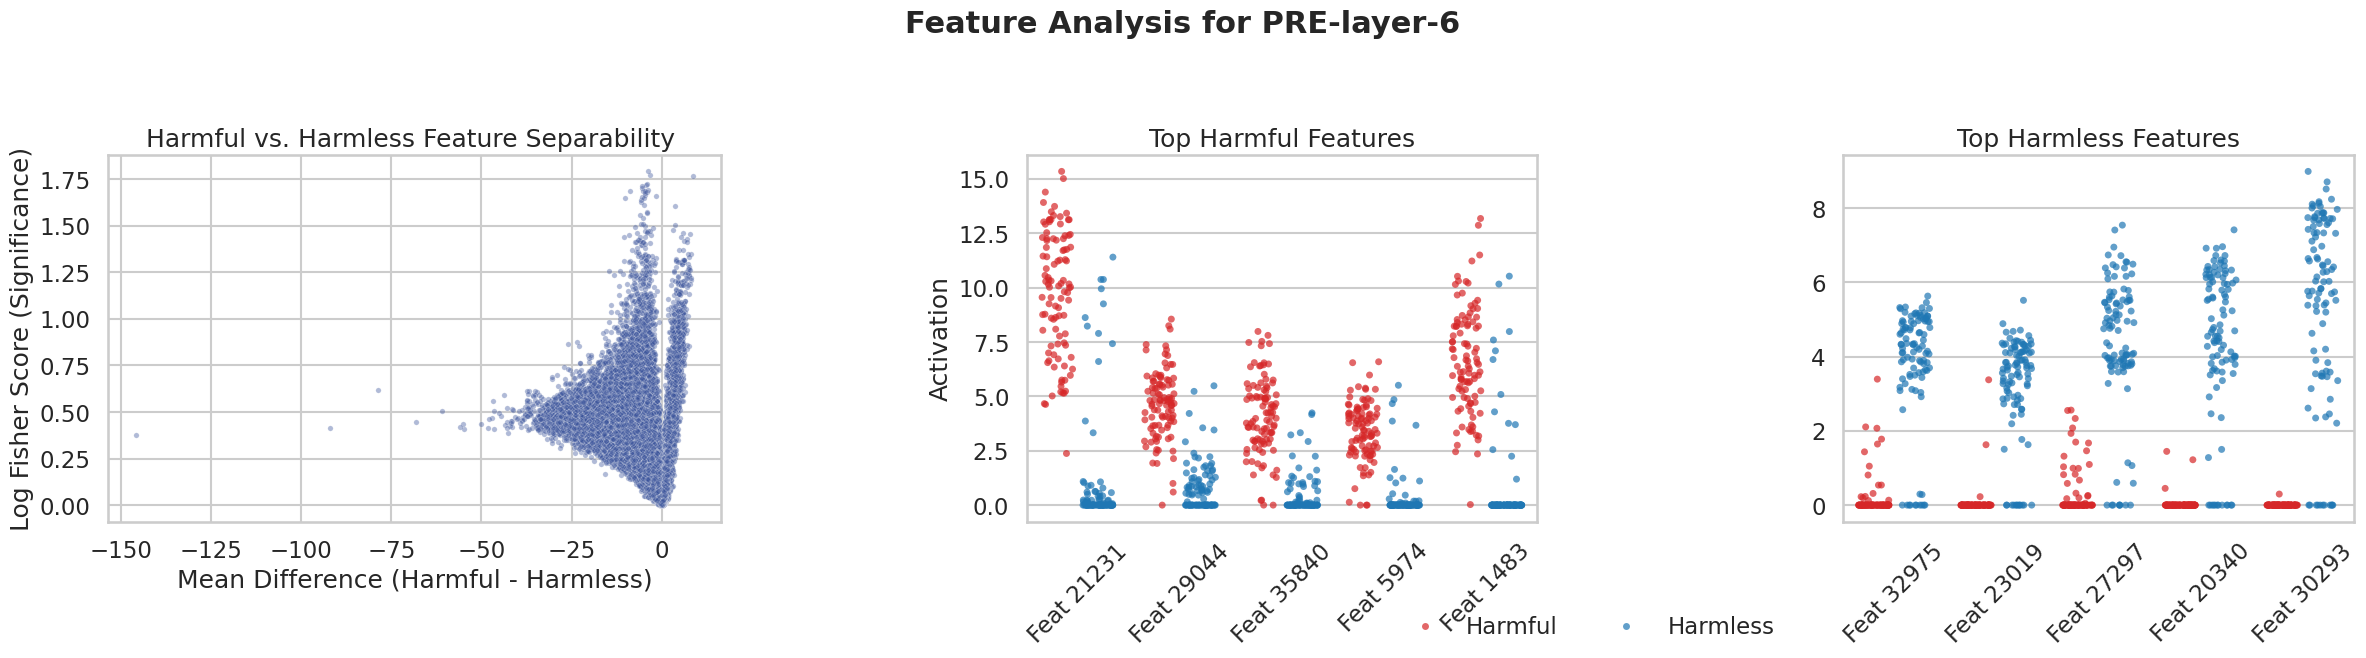

✅ Dashboard saved to: results/visualizations/dashboard_PRE-layer-6.png
Top features overall (harmful):


layer  latent_dim  cohens_d    fisher
0      6       21231  3.116804  4.857234
1      6       29044  2.823676  3.986574
2      6       35840  2.649394  3.509644
3      6        5974  2.603096  3.388056
4      6        1483  2.576975  3.320400

Top features overall (harmless):


layer  latent_dim  cohens_d    fisher
0      6       32975 -3.161594  4.997839
1      6       23019 -3.127378  4.890246
2      6       27297 -3.035491  4.607101
3      6       20340 -3.028601  4.586211
4      6       30293 -3.011526  4.534643

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:11<00:00, 11.41s/it]


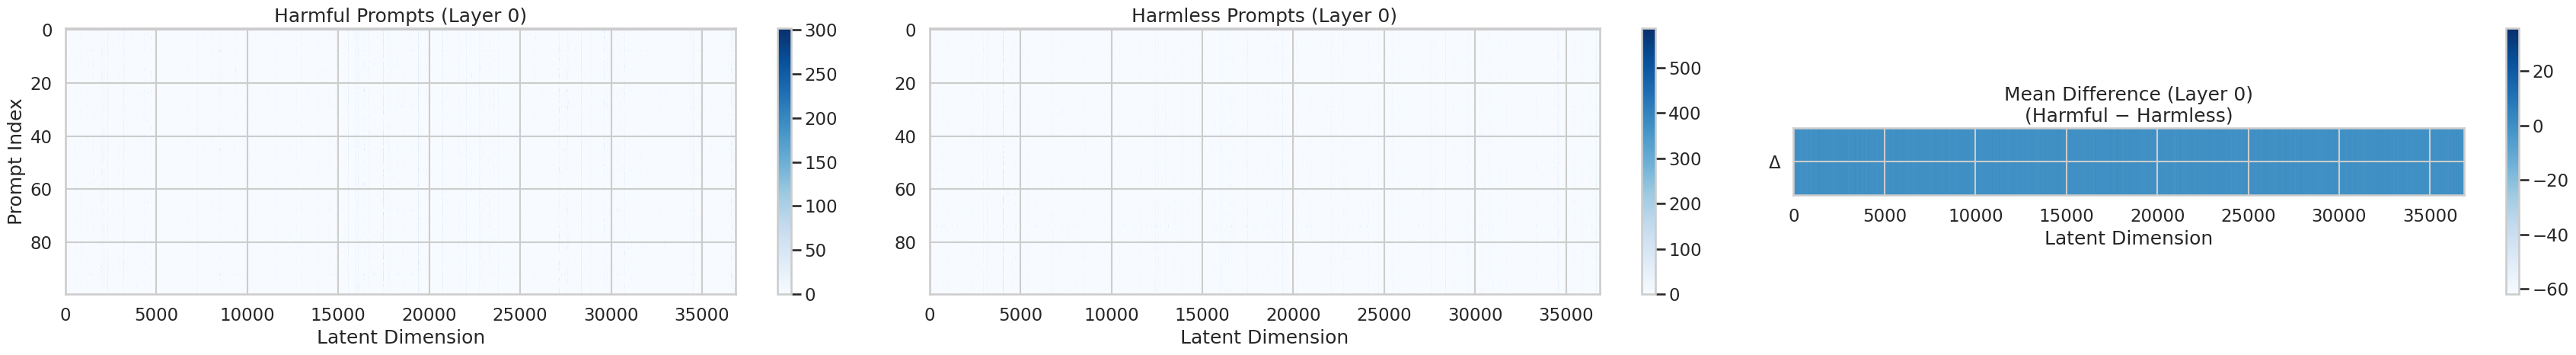

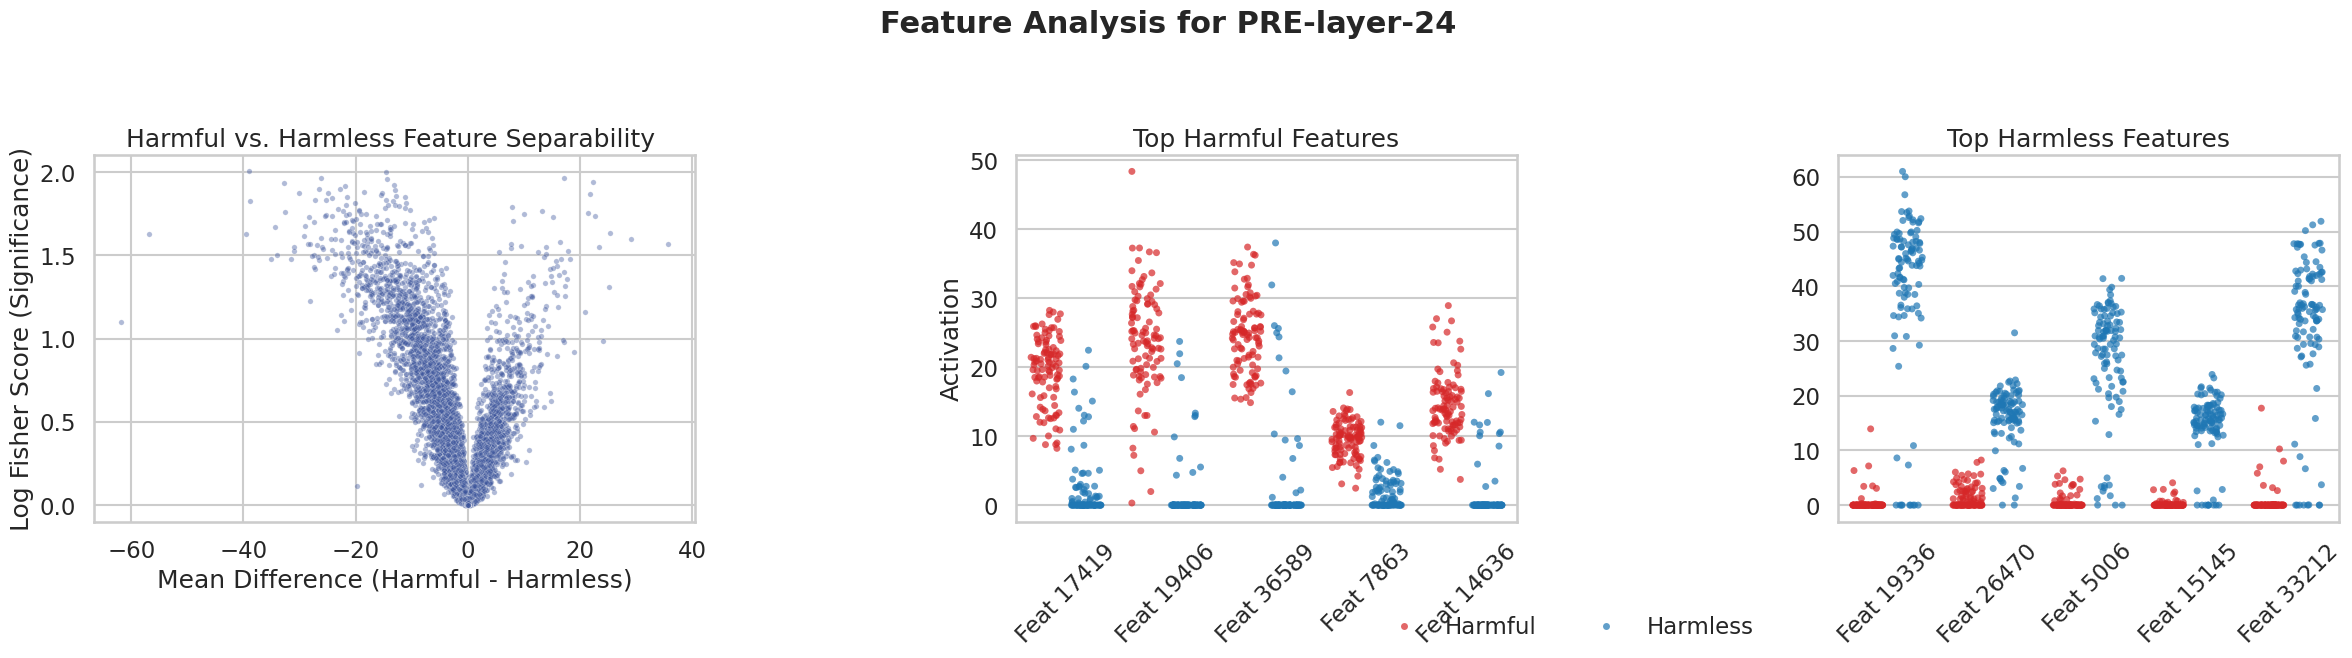

✅ Dashboard saved to: results/visualizations/dashboard_PRE-layer-24.png
Top features overall (harmful):


layer  latent_dim  cohens_d    fisher
0     24       17419  3.495202  6.108218
1     24       19406  3.448766  5.946992
2     24       36589  3.305735  5.463943
3     24        7863  3.153482  4.972224
4     24       14636  3.109736  4.835229

Top features overall (harmless):


layer  latent_dim  cohens_d    fisher
0     24       19336 -3.581215  6.412549
1     24       26470 -3.570873  6.375568
2     24        5006 -3.497315  6.115608
3     24       15145 -3.493609  6.102653
4     24       33212 -3.436194  5.903714

100%|██████████| 1/1 [00:10<00:00, 10.46s/it]


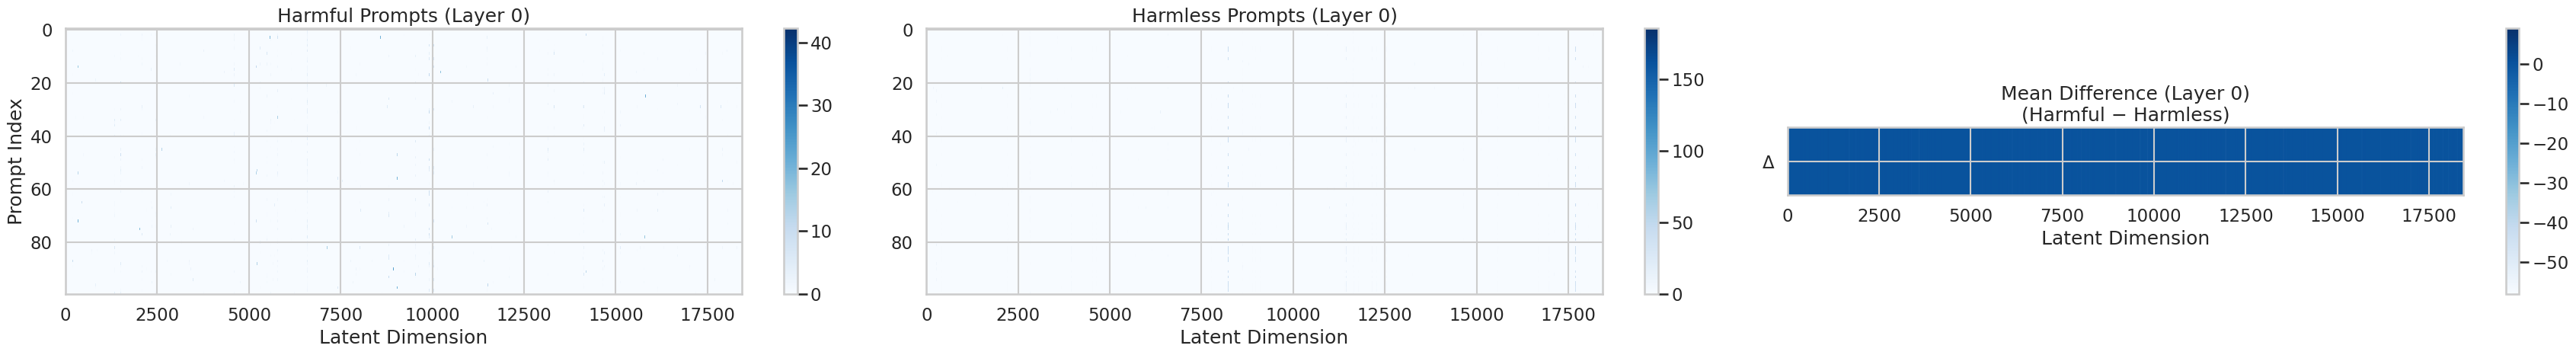

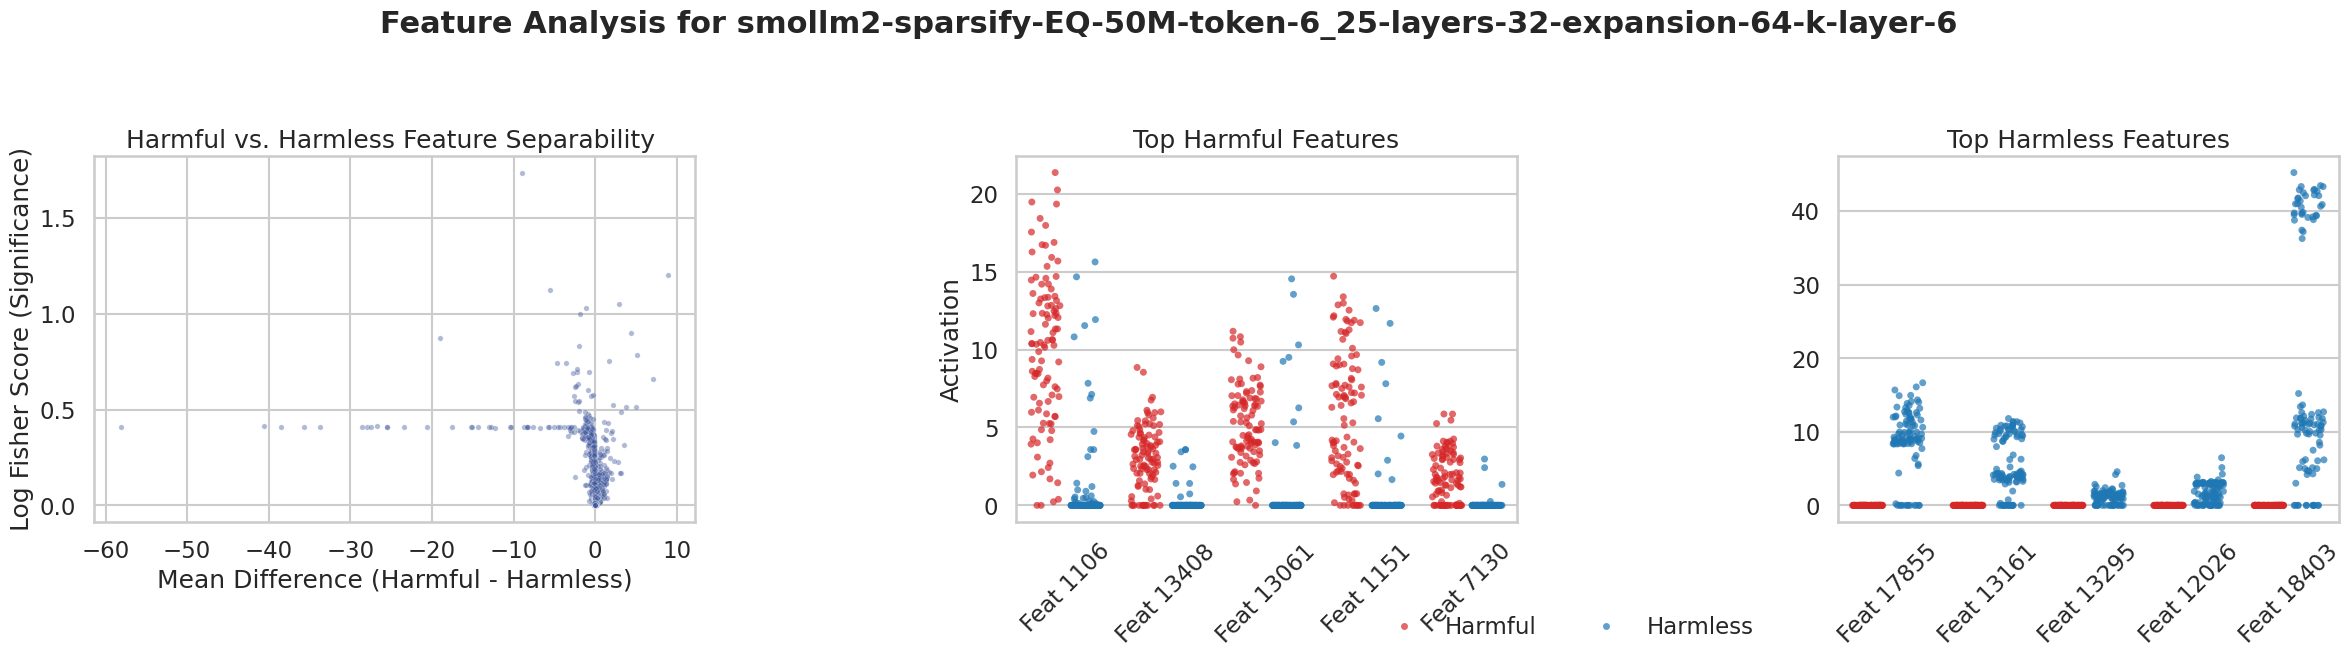

✅ Dashboard saved to: results/visualizations/dashboard_smollm2-sparsify-EQ-50M-token-6_25-layers-32-expansion-64-k-layer-6.png
Top features overall (harmful):


layer  latent_dim  cohens_d    fisher
0      6        1106  2.158418  2.329385
1      6       13408  1.930239  1.862911
2      6       13061  1.704725  1.453044
3      6        1151  1.540842  1.187097
4      6        7130  1.499619  1.124429

Top features overall (harmless):


layer  latent_dim  cohens_d    fisher
0      6       17855 -3.058338  4.676717
1      6       13161 -2.038266  2.077264
2      6       13295 -1.897360  1.799987
3      6       12026 -1.848208  1.707937
4      6       18403 -1.668844  1.392520

100%|██████████| 1/1 [00:10<00:00, 10.29s/it]


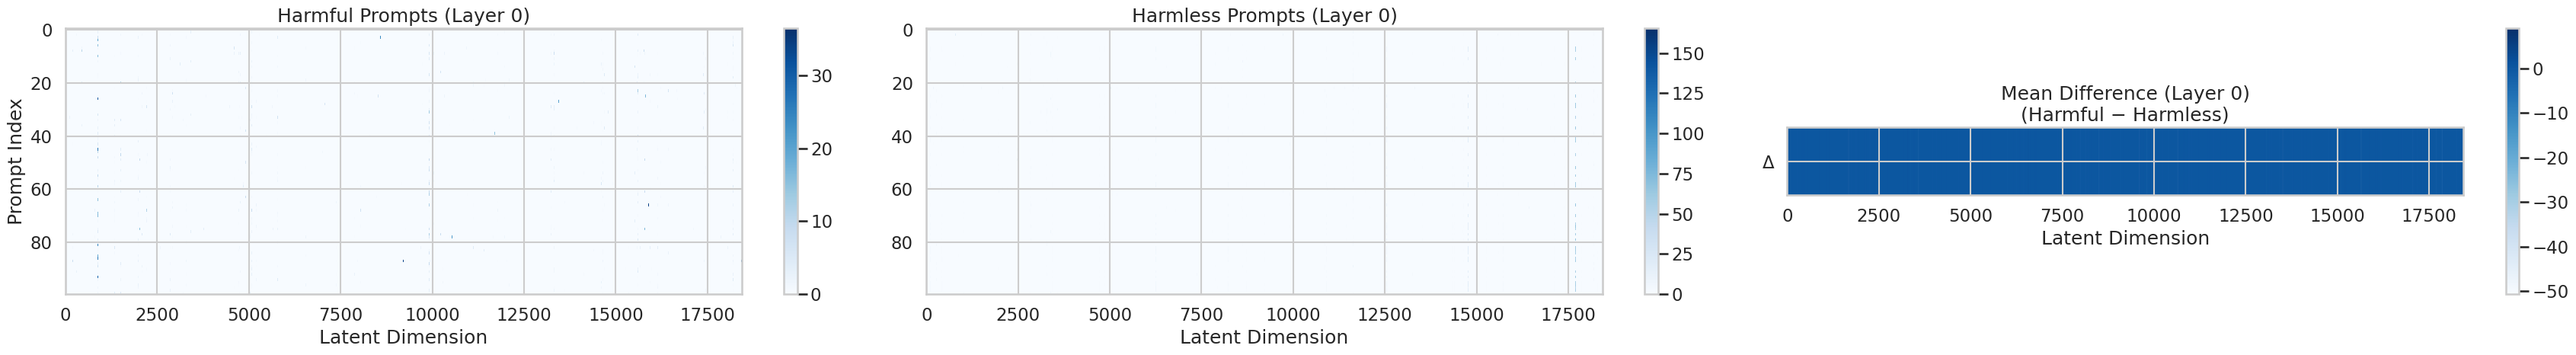

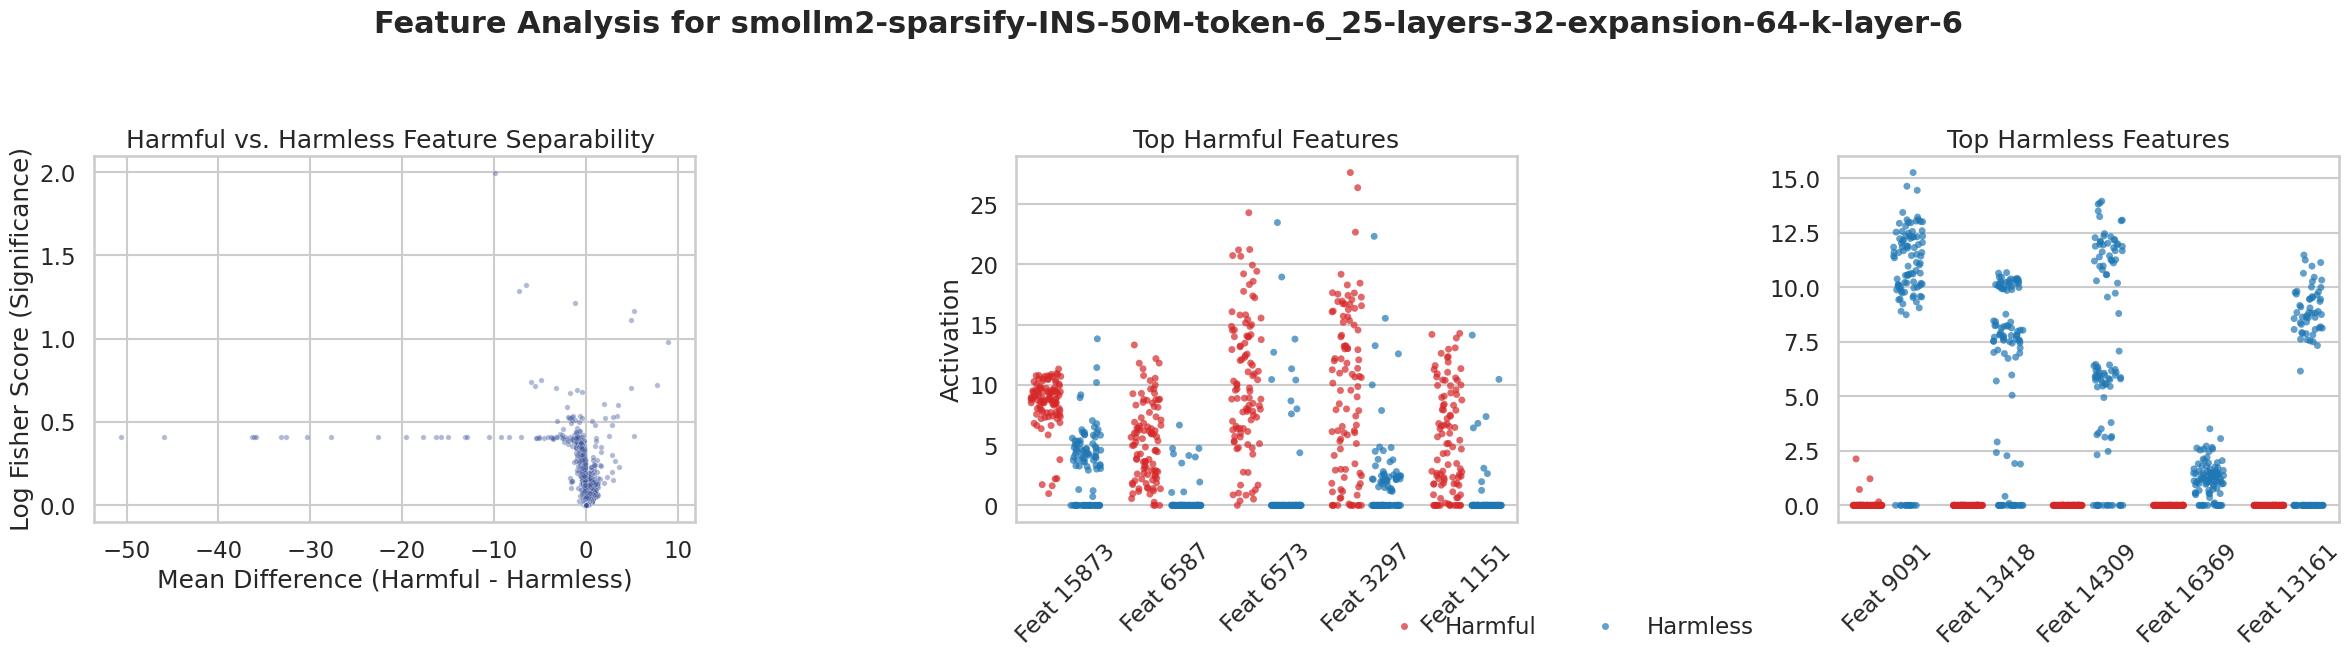

✅ Dashboard saved to: results/visualizations/dashboard_smollm2-sparsify-INS-50M-token-6_25-layers-32-expansion-64-k-layer-6.png
Top features overall (harmful):


layer  latent_dim  cohens_d    fisher
0      6       15873  2.102448  2.210145
1      6        6587  2.018759  2.037694
2      6        6573  1.826144  1.667401
3      6        3297  1.455768  1.059630
4      6        1151  1.432238  1.025653

Top features overall (harmless):


layer  latent_dim  cohens_d    fisher
0      6        9091 -3.570269  6.373411
1      6       13418 -2.342836  2.744441
2      6       14309 -2.289542  2.621001
3      6       16369 -2.177377  2.370486
4      6       13161 -1.500666  1.125999

100%|██████████| 1/1 [00:11<00:00, 11.62s/it]


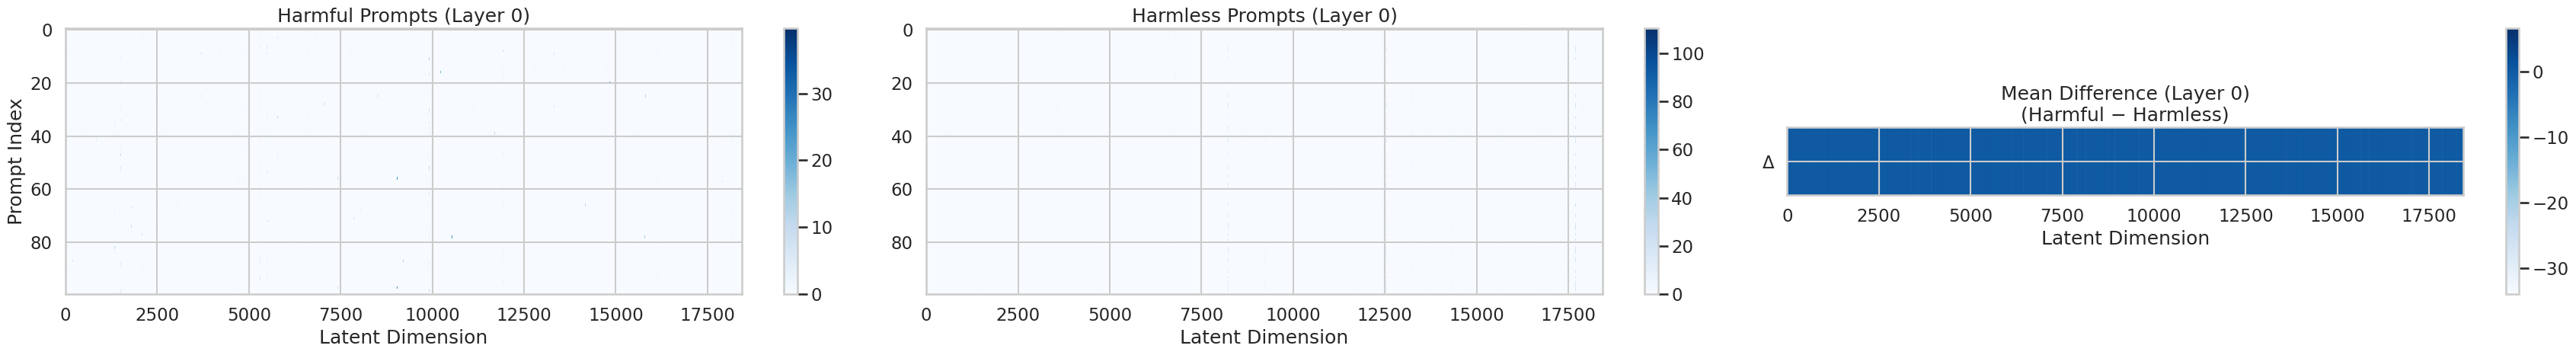

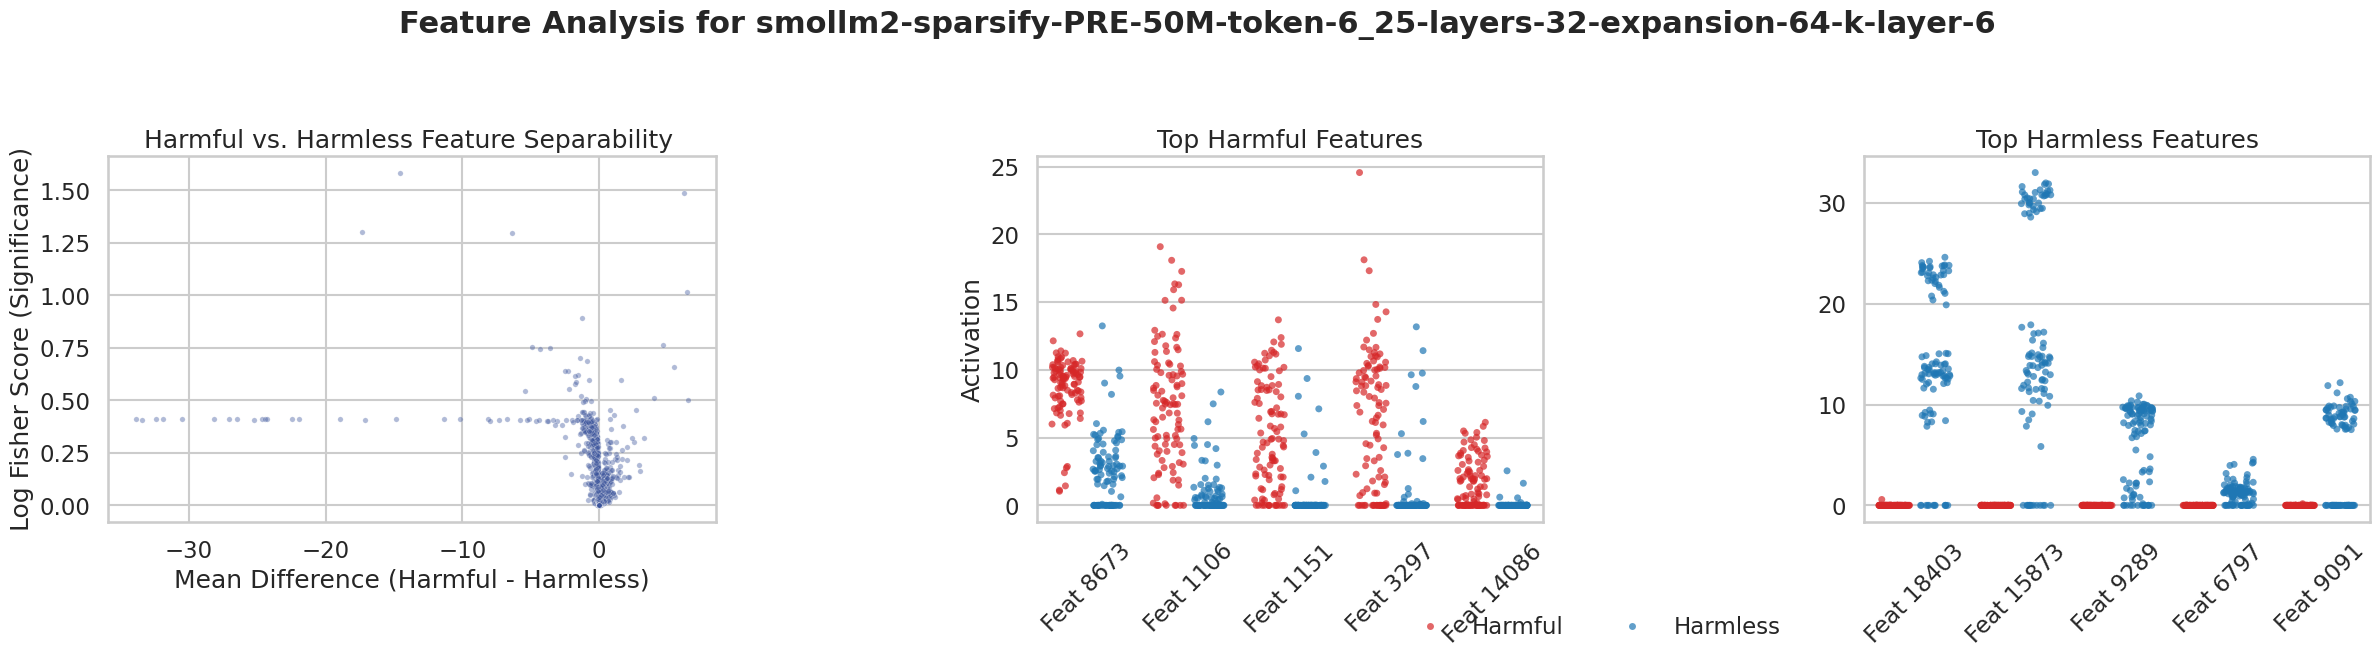

✅ Dashboard saved to: results/visualizations/dashboard_smollm2-sparsify-PRE-50M-token-6_25-layers-32-expansion-64-k-layer-6.png
Top features overall (harmful):


layer  latent_dim  cohens_d    fisher
0      6        8673  2.618051  3.427095
1      6        1106  1.879478  1.766218
2      6        1151  1.513832  1.145844
3      6        3297  1.367760  0.935384
4      6       14086  1.278187  0.816881

Top features overall (harmless):


layer  latent_dim  cohens_d    fisher
0      6       18403 -2.784695  3.877264
1      6       15873 -2.316308  2.682640
2      6        9289 -2.304557  2.655492
3      6        6797 -1.694117  1.435017
4      6        9091 -1.502502  1.128756

100%|██████████| 1/1 [00:11<00:00, 11.28s/it]


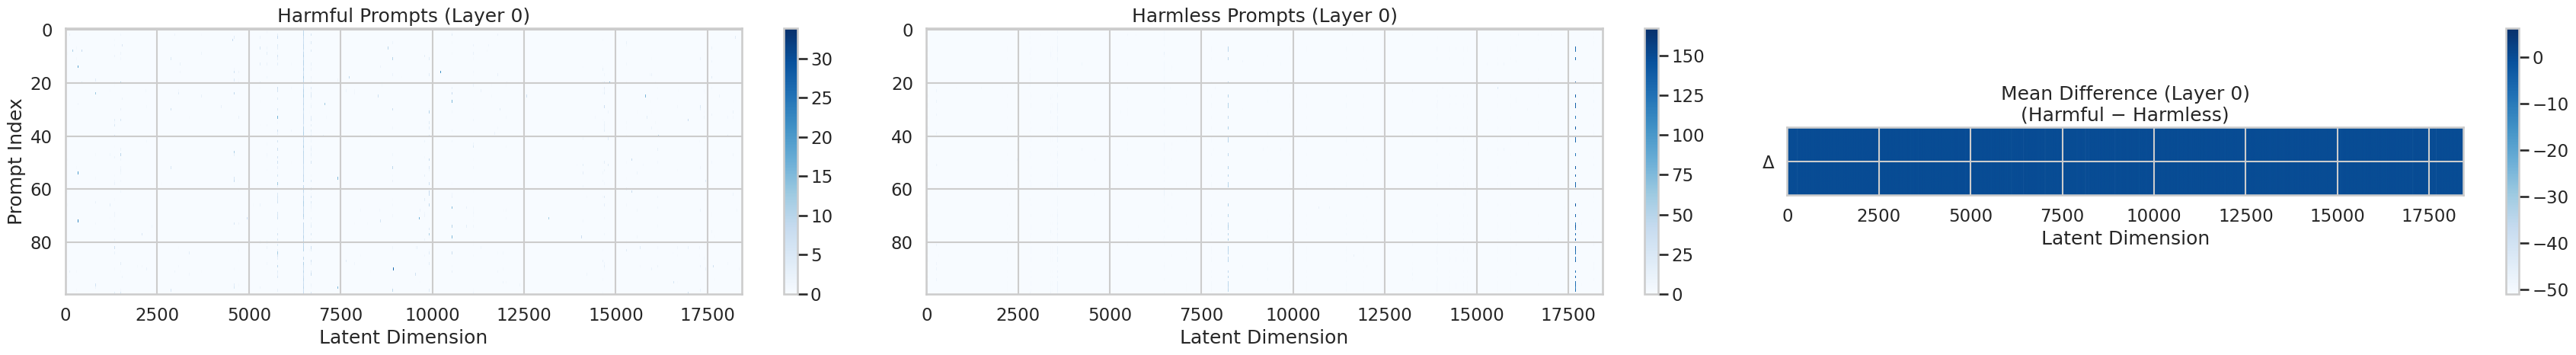

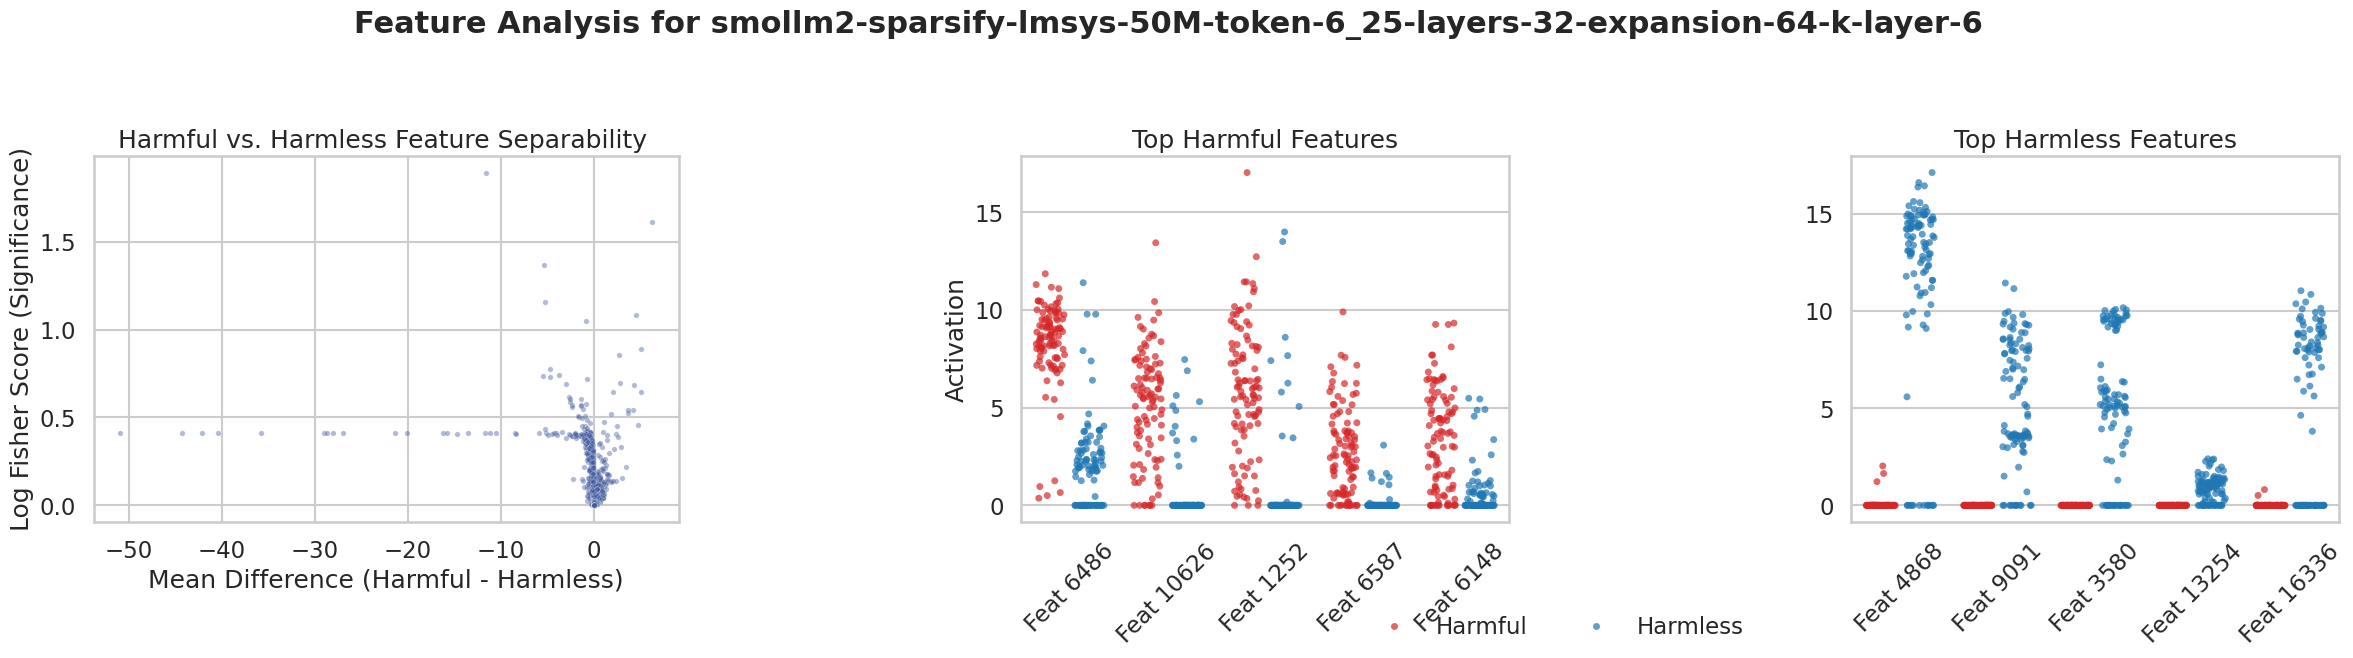

✅ Dashboard saved to: results/visualizations/dashboard_smollm2-sparsify-lmsys-50M-token-6_25-layers-32-expansion-64-k-layer-6.png
Top features overall (harmful):


layer  latent_dim  cohens_d    fisher
0      6        6486  2.830772  4.006636
1      6       10626  1.976594  1.953462
2      6        1252  1.694931  1.436395
3      6        6587  1.646987  1.356282
4      6        6148  1.416742  1.003579

Top features overall (harmless):


layer  latent_dim  cohens_d    fisher
0      6        4868 -3.358355  5.639273
1      6        9091 -2.415862  2.918195
2      6        3580 -2.091856  2.187930
3      6       13254 -1.925360  1.853505
4      6       16336 -1.533163  1.175294

100%|██████████| 1/1 [00:10<00:00, 10.61s/it]


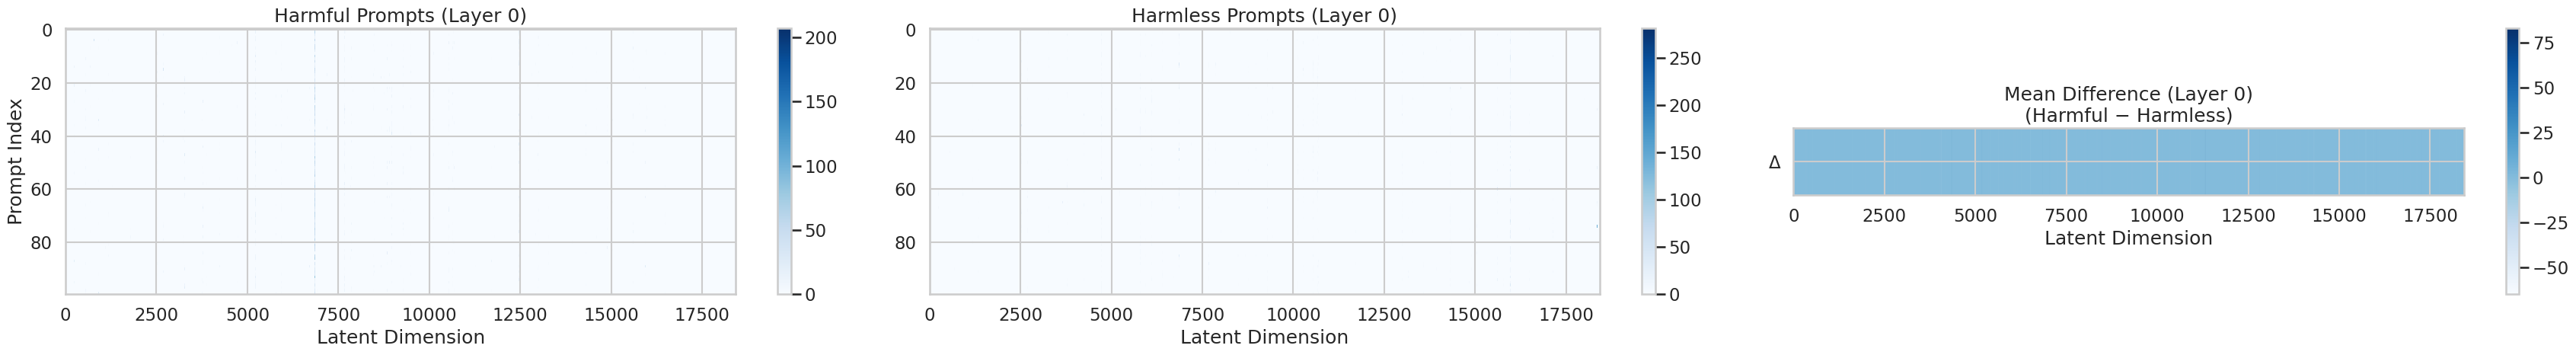

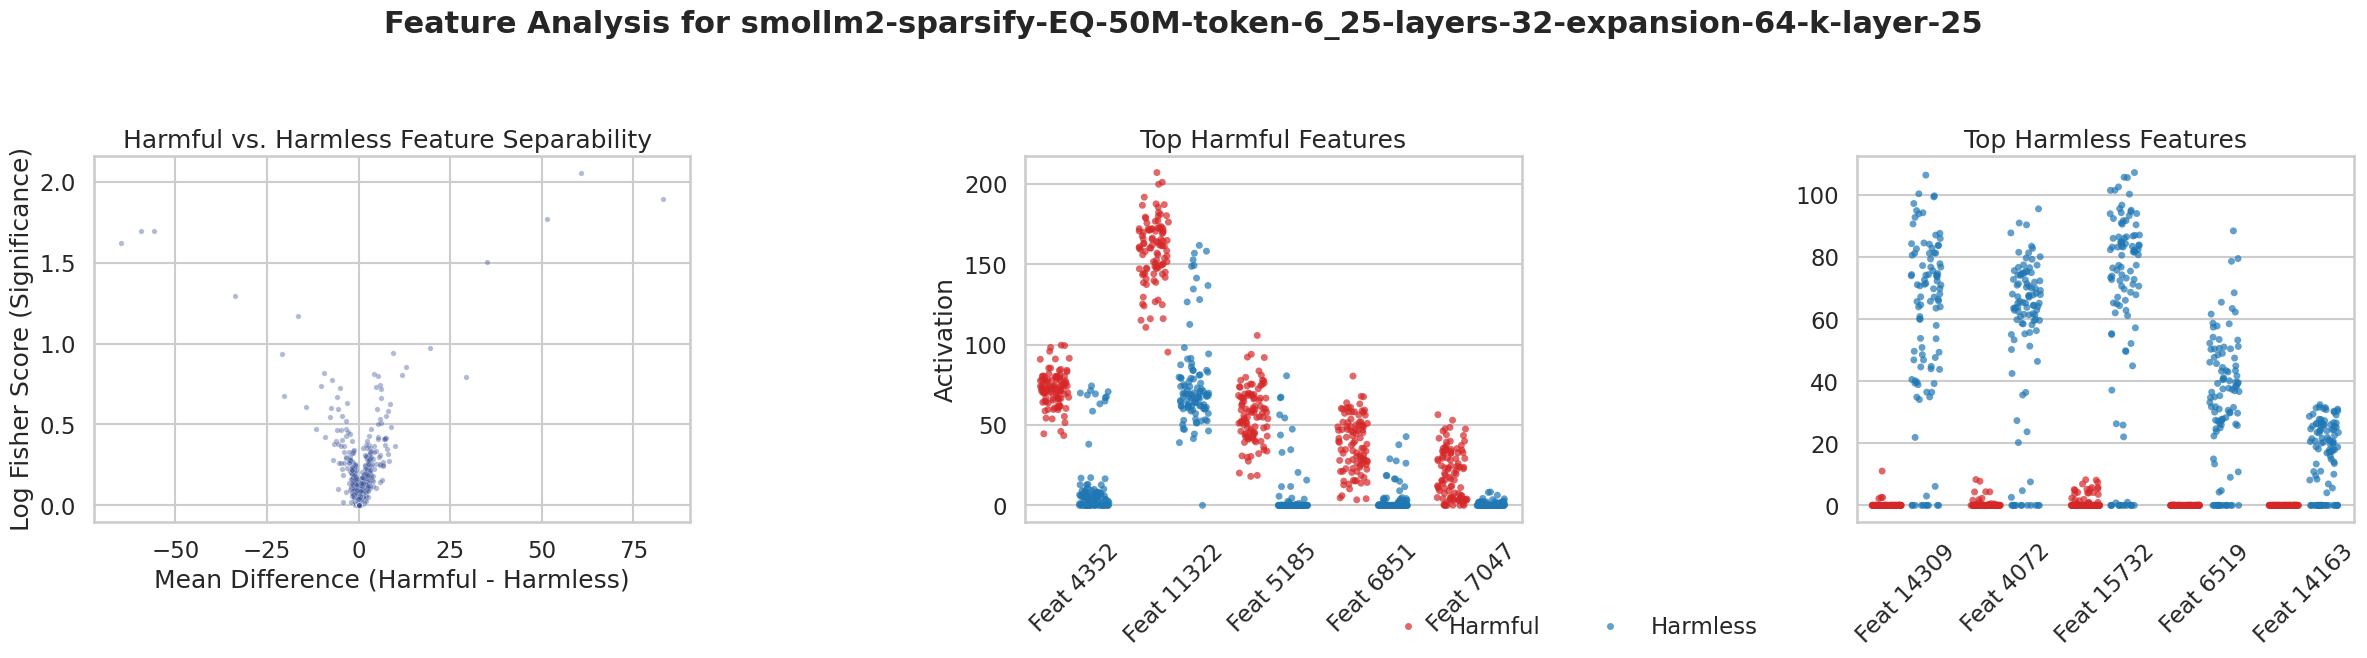

✅ Dashboard saved to: results/visualizations/dashboard_smollm2-sparsify-EQ-50M-token-6_25-layers-32-expansion-64-k-layer-25.png
Top features overall (harmful):


layer  latent_dim  cohens_d    fisher
0     25        4352  3.695749  6.829279
1     25       11322  3.365355  5.662807
2     25        5185  3.117193  4.858446
3     25        6851  2.646028  3.500731
4     25        7047  1.812007  1.641684

Top features overall (harmless):


layer  latent_dim  cohens_d    fisher
0     25       14309 -2.981686  4.445227
1     25        4072 -2.979977  4.440133
2     25       15732 -2.846690  4.051821
3     25        6519 -2.297621  2.639530
4     25       14163 -2.105423  2.216404

100%|██████████| 1/1 [00:11<00:00, 11.03s/it]


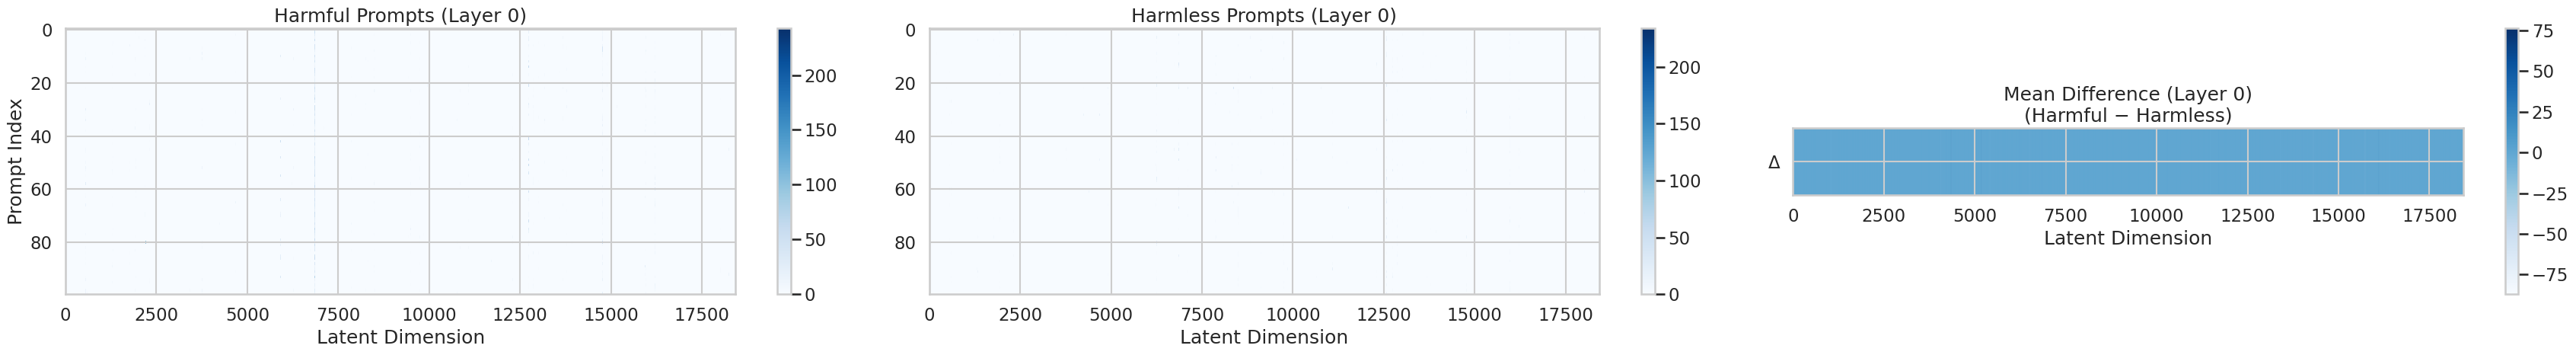

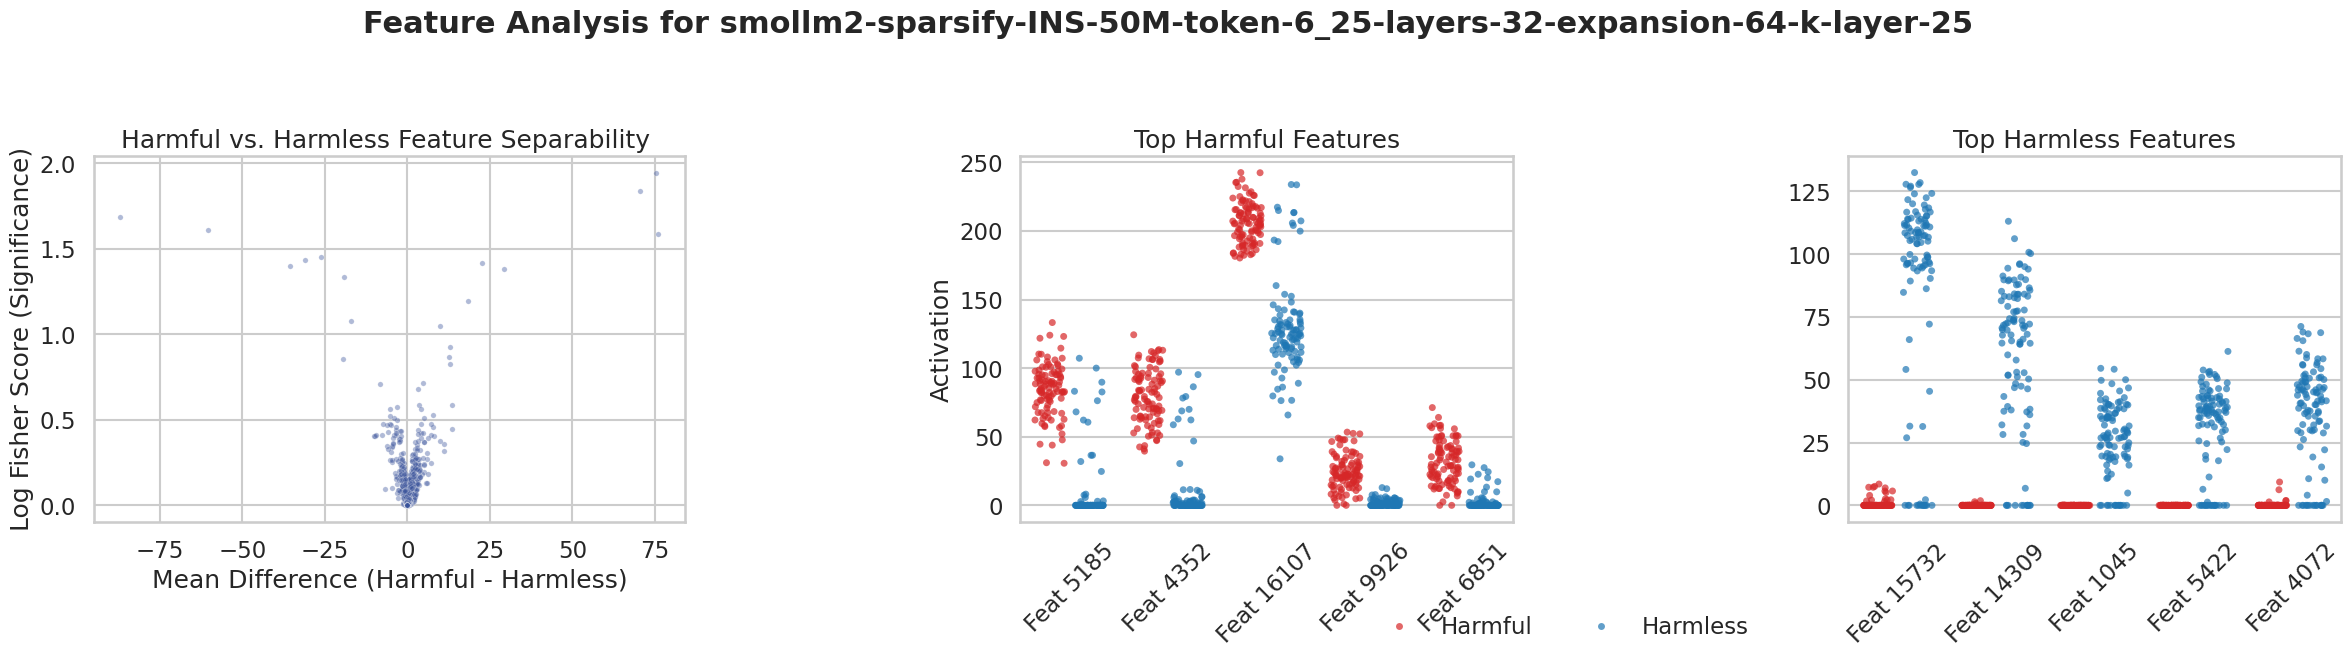

✅ Dashboard saved to: results/visualizations/dashboard_smollm2-sparsify-INS-50M-token-6_25-layers-32-expansion-64-k-layer-25.png
Top features overall (harmful):


layer  latent_dim  cohens_d    fisher
0     25        5185  3.465262  6.004021
1     25        4352  3.254759  5.296726
2     25       16107  2.790222  3.892669
3     25        9926  2.496437  3.116098
4     25        6851  2.445572  2.990412

Top features overall (harmless):


layer  latent_dim  cohens_d    fisher
0     25       15732 -2.962533  4.388299
1     25       14309 -2.832427  4.011321
2     25        1045 -2.563774  3.286469
3     25        5422 -2.527927  3.195208
4     25        4072 -2.468007  3.045529

100%|██████████| 1/1 [00:11<00:00, 11.60s/it]


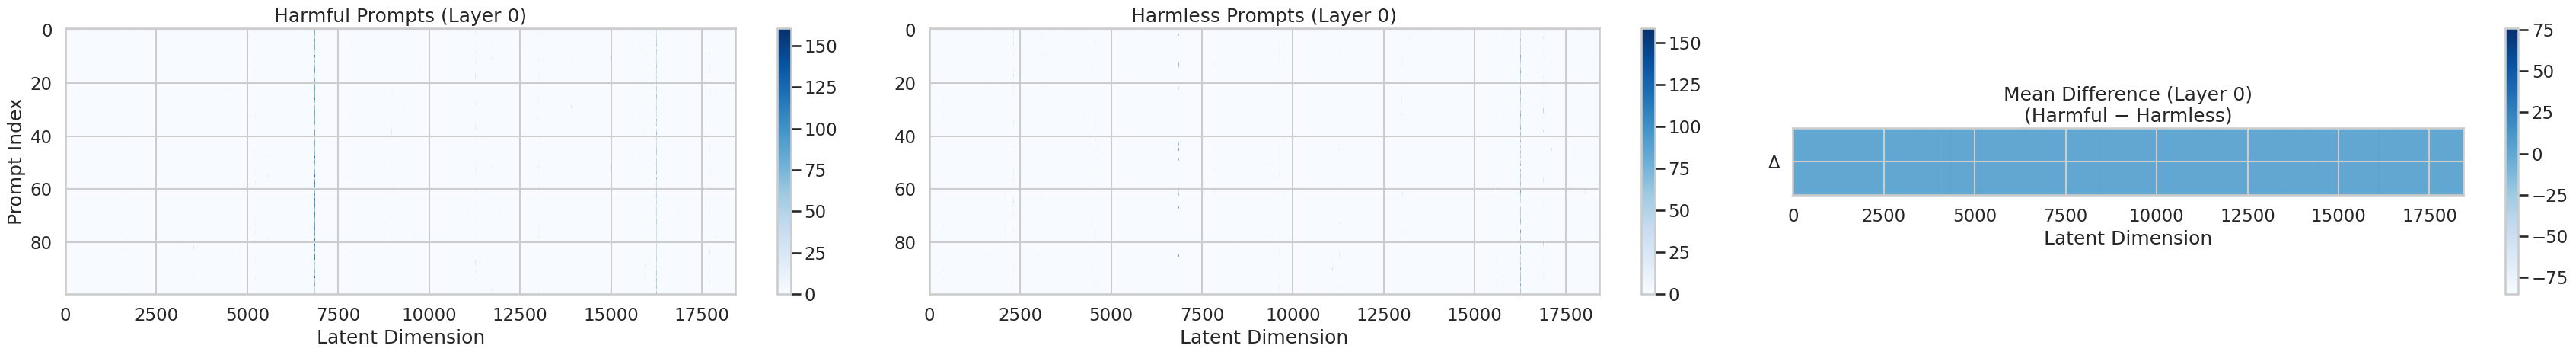

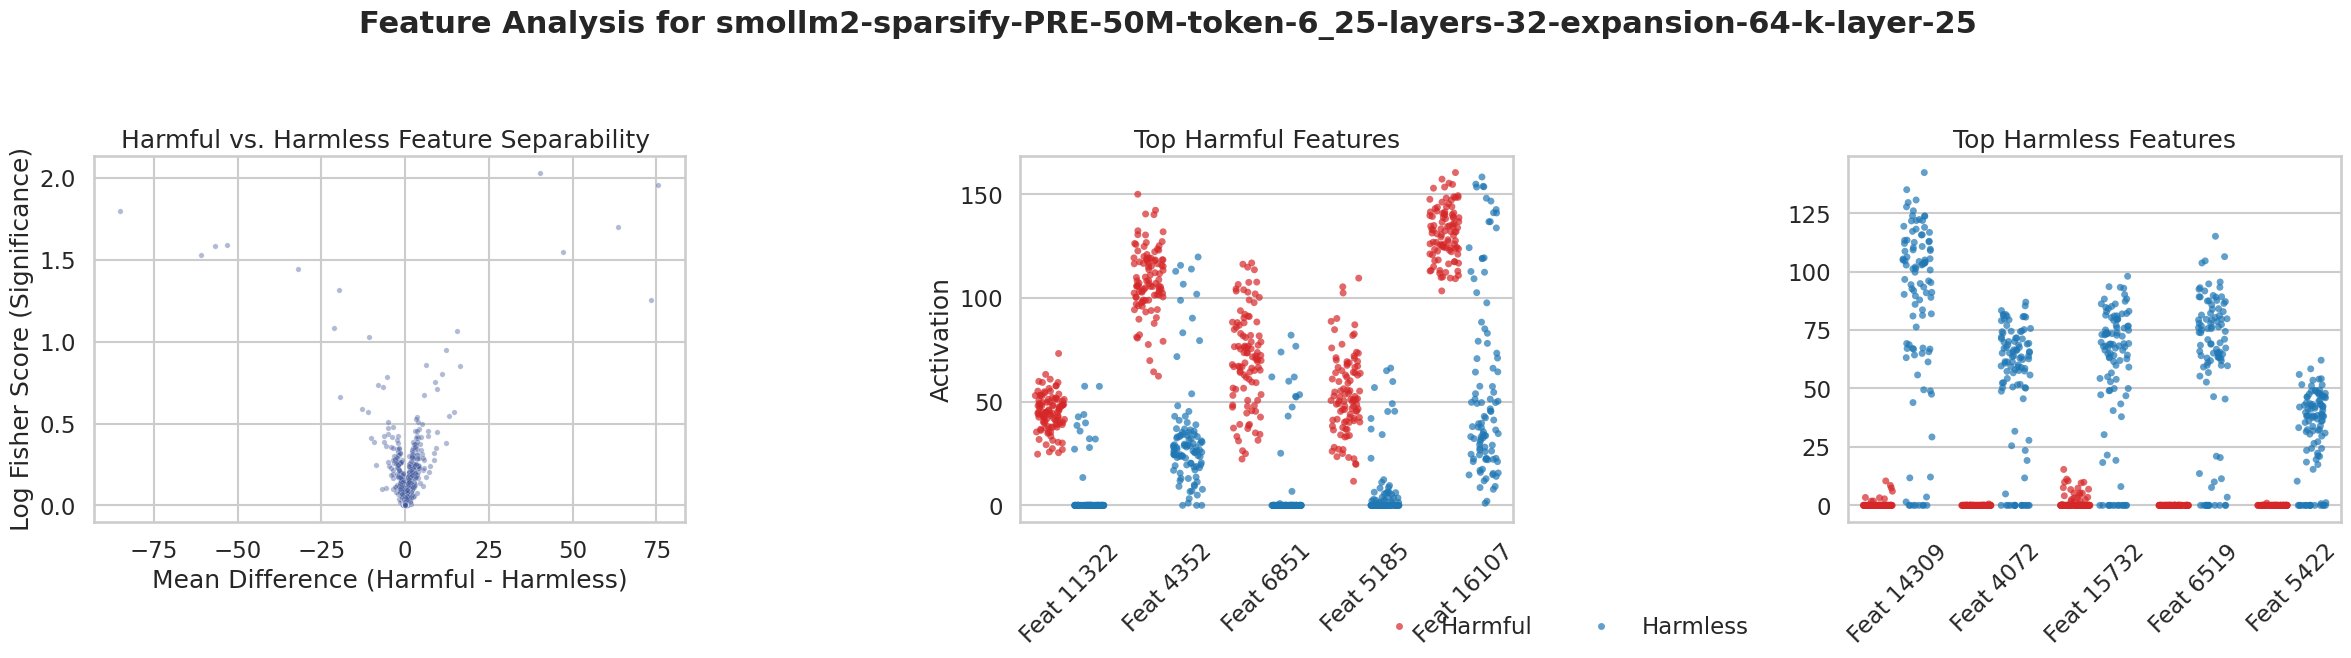

✅ Dashboard saved to: results/visualizations/dashboard_smollm2-sparsify-PRE-50M-token-6_25-layers-32-expansion-64-k-layer-25.png
Top features overall (harmful):


layer  latent_dim  cohens_d    fisher
0     25       11322  3.644763  6.642147
1     25        4352  3.487426  6.081069
2     25        6851  2.995827  4.487489
3     25        5185  2.718310  3.694604
4     25       16107  2.239964  2.508719

Top features overall (harmless):


layer  latent_dim  cohens_d    fisher
0     25       14309 -3.170047  5.024598
1     25        4072 -2.798766  3.916545
2     25       15732 -2.780862  3.866598
3     25        6519 -2.692677  3.625256
4     25        5422 -2.549920  3.251047

100%|██████████| 1/1 [00:11<00:00, 11.09s/it]


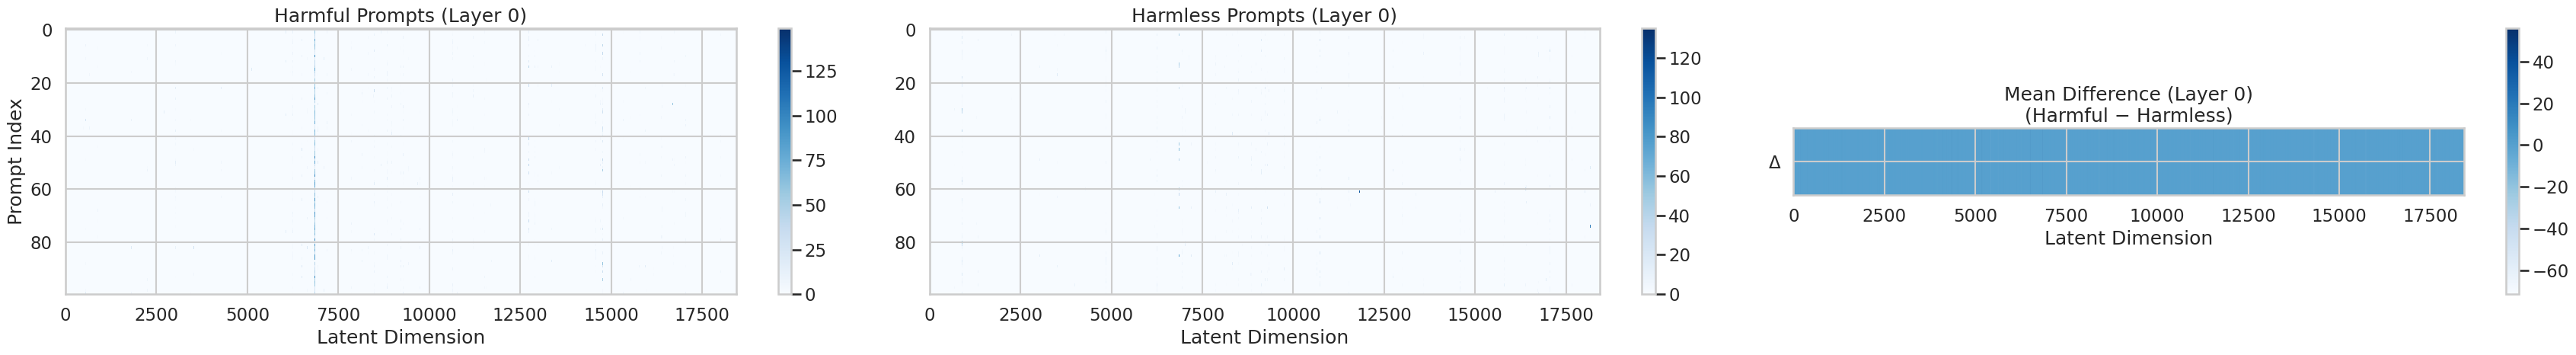

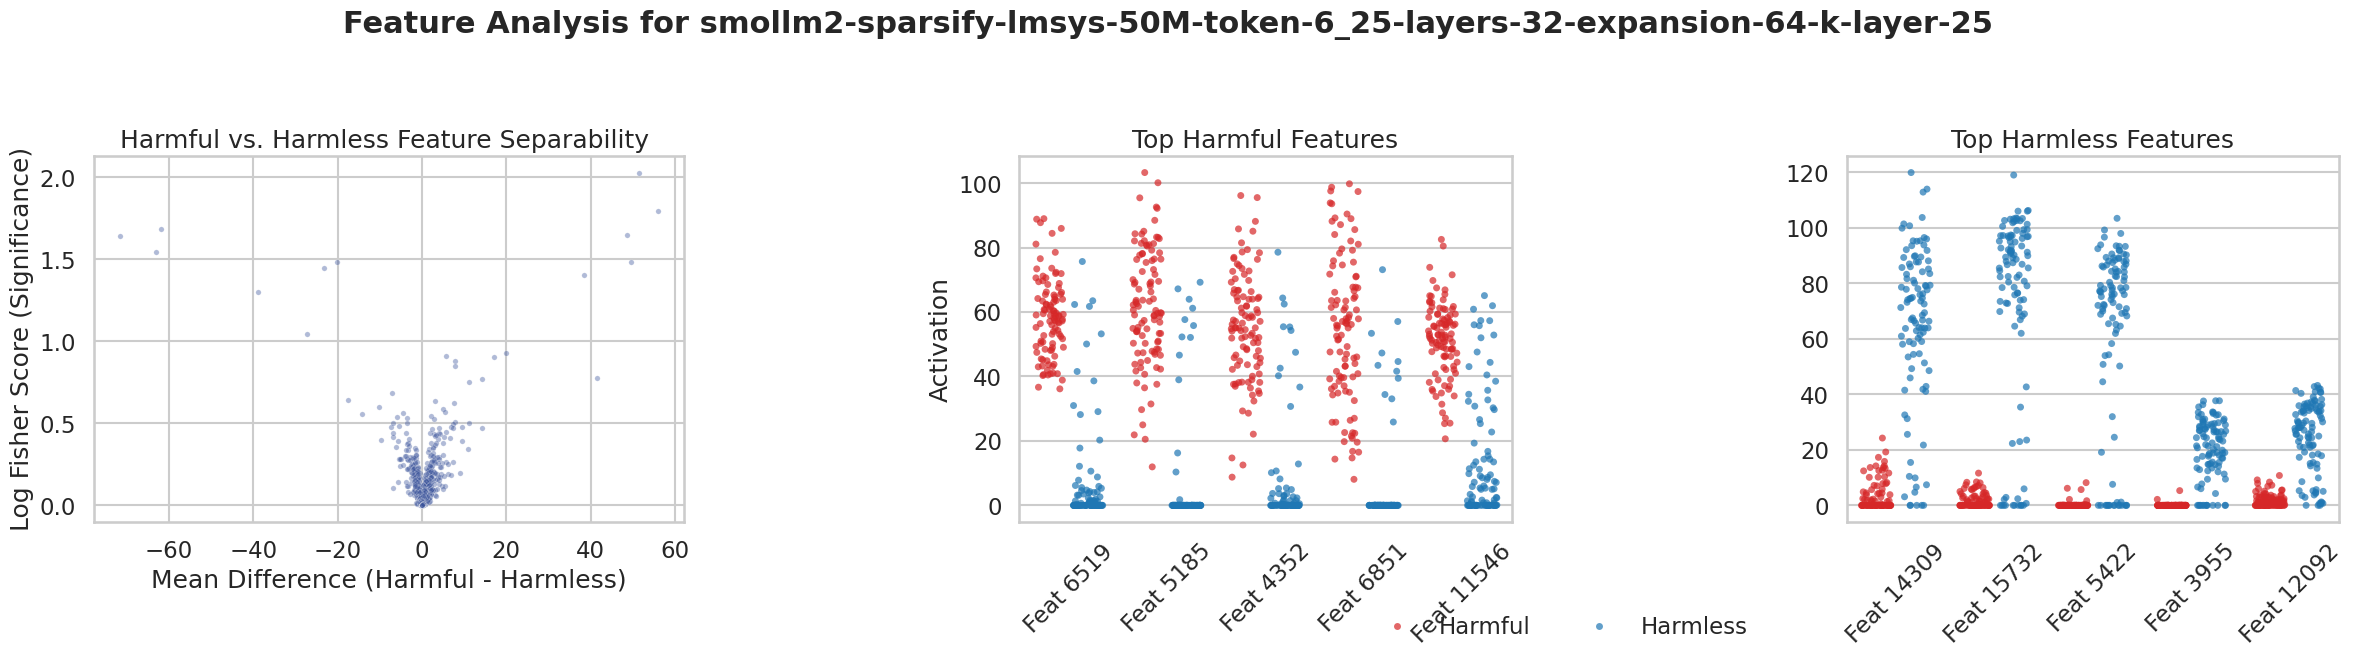

✅ Dashboard saved to: results/visualizations/dashboard_smollm2-sparsify-lmsys-50M-token-6_25-layers-32-expansion-64-k-layer-25.png
Top features overall (harmful):


layer  latent_dim  cohens_d    fisher
0     25        6519  3.634589  6.605118
1     25        5185  3.164472  5.006941
2     25        4352  2.897099  4.196592
3     25        6851  2.607398  3.399261
4     25       11546  2.482502  3.081409

Top features overall (harmless):


layer  latent_dim  cohens_d    fisher
0     25       14309 -2.960030  4.380888
1     25       15732 -2.889141  4.173569
2     25        5422 -2.718963  3.696380
3     25        3955 -2.613784  3.415932
4     25       12092 -2.545561  3.239940

In [15]:
for idx, sae_config in enumerate(SAES):
    if SAES[idx]["results"] != None:
        continue
    SAES[idx]["results"] = id_refusal_feature_for_sae(
        sae_config, 
        # looks at all features, use this to generate vis
        # top_N = int(BASE_HIDDEN_SIZE*sae_config["exp_factor"]),
        top_N = 100,
        rank_metric = "cohens_d",
        layers = [sae_config["layer"]],
        visualise_top_features = True,
        visualise_latent_difference = True
    )

### Potent Feature Count

In [23]:
SAES[0]

{'name': 'PRE',
 'path': 'EleutherAI/sae-SmolLM2-135M-64x',
 'exp_factor': 64,
 'max_length': 1024,
 'is_local': False,
 'results': {'top_harmful':     layer  latent_dim  cohens_d    fisher
  0       6       21231  3.116804  4.857234
  1       6       29044  2.823676  3.986574
  2       6       35840  2.649394  3.509644
  3       6        5974  2.603096  3.388056
  4       6        1483  2.576975  3.320400
  ..    ...         ...       ...       ...
  95      6       34232  1.952574  1.906272
  96      6        7285  1.952493  1.906114
  97      6       12699  1.952404  1.905941
  98      6       23725  1.946937  1.895281
  99      6       10761  1.945688  1.892850
  
  [100 rows x 4 columns],
  'top_harmless':     layer  latent_dim  cohens_d    fisher
  0       6       32975 -3.161594  4.997839
  1       6       23019 -3.127378  4.890246
  2       6       27297 -3.035491  4.607101
  3       6       20340 -3.028601  4.586211
  4       6       30293 -3.011526  4.534643
  ..    ...      

In [30]:
import pandas as pd
import numpy as np

def analyze_feature_potency(saes_data, d_percentile=0.9, f_percentile=0.9, method='dual_threshold'):
    """
    Analyzes and scores feature potency using various methods.

    Args:
        saes_data (list): List of SAE result dictionaries.
        d_percentile (float): Percentile for Cohen's d threshold.
        f_percentile (float): Percentile for Fisher score threshold.
        method (str): The analysis method to use. One of:
                      'hard_count', 'dual_threshold', 'weighted_sigmoid'.

    Returns:
        tuple: A dictionary of results and a dictionary of calculated thresholds.
    """
    all_d_scores = []
    all_f_scores = []
    # This initial loop pools all scores to establish experiment-wide benchmarks,
    # ensuring a fair comparison across all models and layers.
    for sae in saes_data:
        df = sae.get('results', {}).get('top_harmful')
        if df is not None and not df.empty:
            if 'cohens_d' in df.columns:
                all_d_scores.extend(df['cohens_d'].tolist())
            if 'fisher' in df.columns:
                all_f_scores.extend(df['fisher'].tolist())

    if not all_d_scores:
        return {}, {}

    # Calculate global thresholds based on the pooled data distributions.
    thresholds = {
        'd': pd.Series(all_d_scores).quantile(d_percentile),
        'f': pd.Series(all_f_scores).quantile(f_percentile) if all_f_scores else None
    }

    results = {}
    for sae in saes_data:
        result_key = (sae.get('name', 'Unknown'), sae.get('layer', 'N/A'))
        df = sae.get('results', {}).get('top_harmful')

        if df is None or df.empty or 'cohens_d' not in df.columns:
            results[result_key] = {'score': 0, 'top_10_avg_d': 0}
            continue

        score = 0
        if method == 'hard_count':
            # This is the original method, counting features above a single threshold.
            score = (df['cohens_d'] >= thresholds['d']).sum()

        elif method == 'dual_threshold':
            # This method is more robust by requiring features to be both
            # high-impact (Cohen's d) and statistically significant (Fisher).
            if thresholds['f'] is None:
                raise ValueError("Fisher scores not available for 'dual_threshold' method.")
            potent_mask = (df['cohens_d'] >= thresholds['d']) & (df['fisher'] >= thresholds['f'])
            score = potent_mask.sum()

        elif method == 'weighted_sigmoid':
            # This provides a "soft count" that rewards higher d-scores more,
            # avoiding the brittleness of a hard threshold.
            # The 'k' parameter controls the steepness; k=2 is a reasonable start.
            k = 0.7
            d0 = thresholds['d'] # Use the percentile as the sigmoid midpoint.
            weights = 1 / (1 + np.exp(-k * (df['cohens_d'] - d0)))
            score = weights.sum()

        results[result_key] = {
            'score': score,
            'top_10_avg_d': df.head(10)['cohens_d'].mean()
        }

    return results, thresholds


potent_counts, thresholds = analyze_feature_potency(SAES, method='dual_threshold')
print(f"\n--- Dual Threshold Results (d > {thresholds['d']:.2f}, f > {thresholds['f']:.2f}) ---")
sorted_results = sorted(potent_counts.items(), key=lambda item: item[1]['score'], reverse=True)
for (name, layer), data in sorted_results:
    print(f"  {simplify_name(name) if len(name) > 3 else name} (Layer {layer}): Potent Feature Count = {data['score']}")


--- Dual Threshold Results (d > 2.27, f > 2.58) ---
  PRE (Layer 24): Potent Feature Count = 51
  PRE (Layer 6): Potent Feature Count = 29
  MIX-INS (Layer 25): Potent Feature Count = 5
  INS (Layer 25): Potent Feature Count = 5
  MIX-EQ (Layer 25): Potent Feature Count = 4
  MIX-PRE (Layer 25): Potent Feature Count = 4
  MIX-PRE (Layer 6): Potent Feature Count = 1
  INS (Layer 6): Potent Feature Count = 1
  MIX-EQ (Layer 6): Potent Feature Count = 0
  MIX-INS (Layer 6): Potent Feature Count = 0

--- Weighted Sigmoid Results (midpoint d = 2.27) ---
  PRE (Layer 24): Effective Potent Features = 51.26
  PRE (Layer 6): Effective Potent Features = 48.74
  INS (Layer 25): Effective Potent Features = 29.91
  MIX-PRE (Layer 25): Effective Potent Features = 29.70
  MIX-EQ (Layer 25): Effective Potent Features = 29.66
  MIX-INS (Layer 25): Effective Potent Features = 29.14
  INS (Layer 6): Effective Potent Features = 25.80
  MIX-INS (Layer 6): Effective Potent Features = 25.57
  MIX-EQ (Layer 

**Plotting the effect sizes for all SAEs**

/tmp/ipykernel_1169929/1058317764.py:75: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='lower right', title='Effect Type')


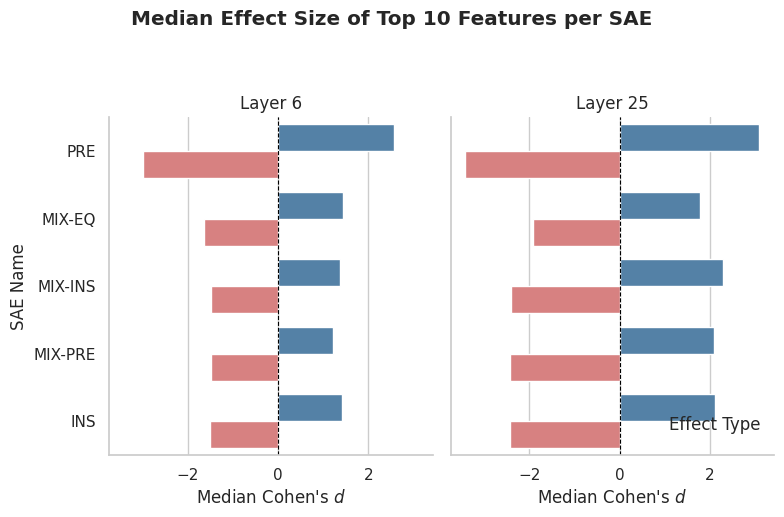

In [55]:
def plot_median_effects_seaborn(saes_data, top_n=25):
    """
    Creates a faceted, grouped horizontal bar plot using Seaborn to compare
    the median Cohen's d of top-N features, separated by layer.

    This version includes custom name simplification and a data hotfix.

    Args:
        saes_data (list): Your list of SAE dictionaries (the SAES variable).
        top_n (int): The number of top features to use for calculating the median.
    """
    summary_data = []
    # --- 1. Extract data, keeping layer and name separate ---
    for sae in saes_data:
        harmful_df = sae.get('results', {}).get('top_harmful')
        harmless_df = sae.get('results', {}).get('top_harmless')

        summary_data.append({
            "name": sae.get('name', 'Unknown'),
            "layer": sae.get('layer', 'N/A'),
            "Harmful": harmful_df.head(top_n)['cohens_d'].median() if harmful_df is not None else 0,
            "Harmless": harmless_df.head(top_n)['cohens_d'].median() if harmless_df is not None else 0
        })

    if not summary_data:
        print("No data to plot.")
        return
    
    df_wide = pd.DataFrame(summary_data)

    # Create the simplified name column for y-axis labels
    df_wide['sae_name'] = df_wide.apply(
        lambda row: f"{simplify_name(row['name'])}" if len(row["name"]) > 10 else row["name"],
        axis=1
    )
    
    # --- 2. Apply hotfix and name simplification ---
    # HOTFIX: Re-assign layer for specific PRE variant
    df_wide.loc[(df_wide['sae_name'] == 'PRE') & (df_wide['layer'] == 24), 'layer'] = 25
    

    # --- 3. Convert to a long-form DataFrame suitable for Seaborn ---
    df_long = df_wide.melt(
        id_vars=['sae_name', 'layer'],
        value_vars=['Harmful', 'Harmless'],
        var_name='Effect Type',
        value_name="Median Cohen's d"
    )

    # --- 4. Create the faceted plot with Seaborn ---
    sns.set_theme(style="whitegrid")
    
    g = sns.catplot(
        data=df_long,
        kind="bar",
        y="sae_name",       # Use the simplified sae_name for the y-axis
        x="Median Cohen's d",
        hue="Effect Type",
        col="layer",        # Facet by layer
        palette={"Harmful": "#4682B4", "Harmless": "#E57373"},
        height=5,
        aspect=0.8,
        legend=False,
        dodge=True         # Ensures bars are grouped side-by-side
    )

    # --- 5. Formatting and Labels ---
    g.set_axis_labels("Median Cohen's $d$", "SAE Name")
    g.set_titles("Layer {col_name}")
    g.fig.suptitle(f"Median Effect Size of Top {top_n} Features per SAE", y=1.03, weight='bold')

    for ax in g.axes.flat:
        ax.axvline(0, color='black', linewidth=0.8, linestyle='--')

    plt.legend(loc='lower right', title='Effect Type')
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()


# --- Example Usage ---
# Assuming 'SAES' is your list of dictionaries defined in your environment,
# you can call the function directly.

plot_median_effects_seaborn(SAES, top_n=10)

### Grid Feature Eval

**This creates a grid config that will be used later to run the grid eval search (`run_steer_feature_grid.slum`).**

In [17]:
import json
import itertools
import pandas as pd
import os

# generate grid search configurations
Cs = [1, 3, 6, 9, 12, 15]  # coefficient magnitudes to test
feature_counts = list(range(1, 11))  # number of features to include
grid = []

# SAES should be defined in the session as a list of dicts,
# each with keys 'sae_id', 'layer', and results['top_harmful'] dataframe.
for sae_config in SAES:
    layer = sae_config["layer"]
    hookpoint = f"layers.{layer}"
    sparse_model = sae_config["path"]
    sae_name = os.path.basename(sparse_model.rstrip("/"))
    top_dims = sae_config["results"]["top_harmful"]["latent_dim"].values

    is_local = "EleutherAI/" not in sparse_model

    for N, C in itertools.product(feature_counts, Cs):
        indices = top_dims[:N].tolist()
        steer_fname = f"{sae_name}-{hookpoint}-N{N}-C{C}.pt"
        out_fname = f"{sae_name}-{hookpoint}-N{N}-C{C}.json"

        grid.append({
            "pretrained": "HuggingFaceTB/SmolLM2-135M",
            "device": "cuda",
            "action": "refusal",
            "hookpoint": hookpoint,
            "layer": layer,
            "sparse_model": sparse_model,
            "is_local": is_local,
            "feature_indices": indices,
            "steering_coefficients": [C] * N,
            "steer_path": f"refusal_dirs/{steer_fname}",
            "out_path": f"results/sae/features/grid/{out_fname}"
        })

# save configs for later runs
with open('evaluation/feature_grid_configs_135M.json', 'w') as f:
    json.dump(grid, f, indent=2)


**Collect & aggregate all results from the grid slurm run**

In [18]:
import os
import json
import glob
import pandas as pd

def aggregate_json_results(input_dir, output_json_path=None):
    """
    Aggregates JSON results from a directory into a Pandas DataFrame and 
    optionally saves the parsed data to a single JSON file.

    Args:
        input_dir (str): The directory containing the individual .json result files.
        output_json_path (str, optional): Path to save the final aggregated and
                                          parsed JSON file. Defaults to None.

    Returns:
        pd.DataFrame: A DataFrame containing the aggregated results.
    """
    json_files = glob.glob(os.path.join(input_dir, '*.json'))
    if not json_files:
        print(f"⚠️ No .json files found in '{input_dir}'.")
        return pd.DataFrame()

    print(f"🔎 Found {len(json_files)} JSON files. Parsing now...")

    records = []
    for file_path in json_files:
        try:
            with open(file_path, 'r') as f:
                data = json.load(f)

            config = data.get("config", {})
            results = data.get("results", {})
            feature_indices = config.get("feature_indices", [])
            steering_coeffs = config.get("steering_coefficients", [])
            
            record = {
                "model": os.path.basename(config.get("sparse_model", "")),
                "hookpoint": config.get("hookpoint"),
                "N": len(feature_indices),
                "C": steering_coeffs[0] if steering_coeffs else None,
                "rr": results.get("refusal_rate"),
                "orr": results.get("open_refusal_rate"),
                "result_path": config.get("out_path")
            }
            records.append(record)
        
        except Exception as e:
            print(f"❌ Failed to process {os.path.basename(file_path)}: {e}")

    # Save the aggregated and parsed records to a JSON file if a path is provided
    if output_json_path:
        print(f"\n💾 Saving {len(records)} parsed records to JSON file...")
        try:
            with open(output_json_path, 'w') as f:
                json.dump(records, f, indent=4)
            print(f"✅ Successfully saved aggregated data to '{output_json_path}'.")
        except Exception as e:
            print(f"❌ Failed to write to output file {output_json_path}: {e}")

    return pd.DataFrame(records)

In [19]:
results_directory = "results/sae/features/grid/"
final_json_output = "results/saes/grid_parsed_135M.json" # Path for the aggregated JSON

# This will create the DataFrame AND save the final JSON file
df = aggregate_json_results(results_directory, output_json_path=final_json_output)

# 3. Display the head of the DataFrame to verify the results.
display(df.head())


🔎 Found 584 JSON files. Parsing now...

💾 Saving 584 parsed records to JSON file...
✅ Successfully saved aggregated data to 'results/saes/grid_parsed_135M.json'.


model  hookpoint  N   C    rr  \
0  smollm2-sparsify-PRE-50M-token-6_25-layers-32-...   layers.6  7   9  0.00   
1  smollm2-sparsify-INS-50M-token-6_25-layers-32-...   layers.6  2  15  0.00   
2  smollm2-sparsify-lmsys-50M-token-6_25-layers-3...   layers.6  1   3  0.01   
3  smollm2-sparsify-lmsys-50M-token-6_25-layers-3...  layers.25  1  15  0.02   
4  smollm2-sparsify-PRE-50M-token-6_25-layers-32-...   layers.6  7   6  0.00   

    orr                                        result_path  
0  0.03  results/sae/features/grid/smollm2-sparsify-PRE...  
1  0.01  results/sae/features/grid/smollm2-sparsify-INS...  
2  0.00  results/sae/features/grid/smollm2-sparsify-lms...  
3  0.01  results/sae/features/grid/smollm2-sparsify-lms...  
4  0.00  results/sae/features/grid/smollm2-sparsify-PRE...

In [20]:
_df = df.copy()
_df['variant'] = _df['model'].apply(simplify_name)
_df['score'] = _df['rr'] - 0.8 * _df['orr']
_df[_df['variant'] == 'PRE'][['rr', 'orr', 'score']].agg(['min', 'max'])

rr   orr  score
min  0.00  0.00 -0.024
max  0.03  0.04  0.030

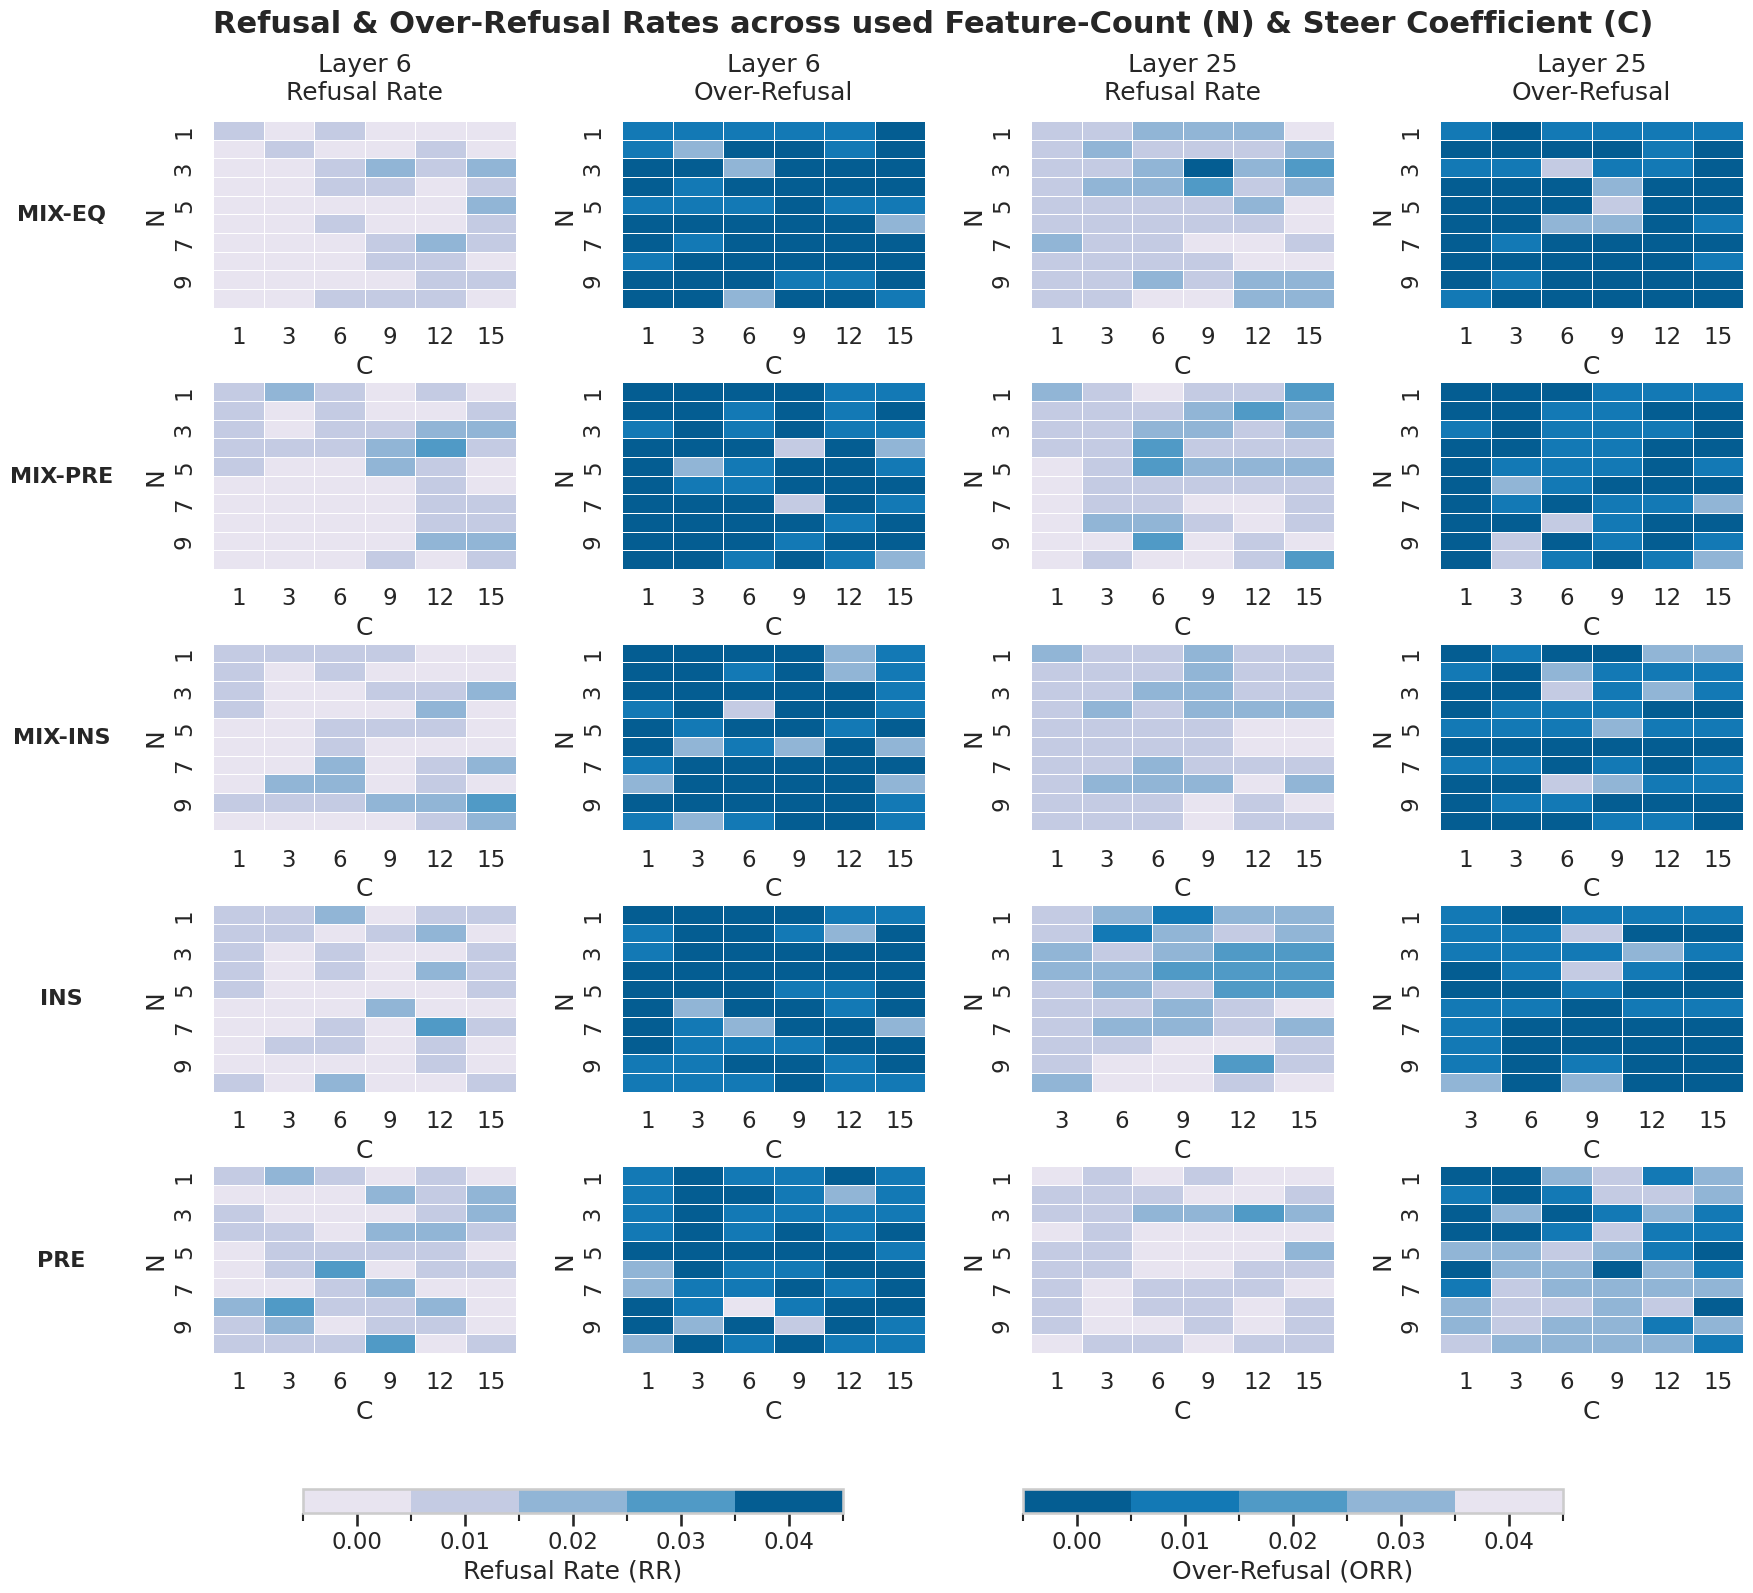

→ saved final heatmaps to results/visualizations/grid_heatmaps.png


In [21]:
import os
from pathlib import Path

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import BoundaryNorm
from matplotlib.colors import ListedColormap

def plot_refusal_heatmaps(df, results_path="results/visualizations",
                          filename="grid_heatmaps.png"):
    """
    4×4 heatmaps of RR & ORR by (N,C) for each SAE variant and layer,
    with variant labels on left and a shared title & colorbars.
    """
    df = df.copy()
    df['variant'] = df['model'].apply(simplify_name)
    df['layer']   = df['hookpoint'].str.split('.').str[1].astype(int)

    # hotfix: 
    df.loc[(df['variant'] == 'PRE') & (df['layer'] == 24), 'layer'] = 25

    variants = ["MIX-EQ","MIX-PRE","MIX-INS","INS", "PRE"]
    layers   = [6, 25]
    max_rr   = df['rr'].max() 
    max_orr  = df['orr'].max()
    metrics  = [
        ("rr",  "Refusal Rate",  max_rr),
        ("orr", "Over-Refusal",   max_orr)
    ]

    # 3) Build discrete colormaps
    # viridis, Blues, PuBu, Spectral, Cividis
    distinct_colors   = sns.color_palette("PuBu") # , n_colors=5)
    cmap_rr  = ListedColormap(distinct_colors)
    cmap_orr = ListedColormap(list(reversed(distinct_colors)))

    sns.set_theme(style="whitegrid", context="talk")

    # 4) Create subplots grid
    fig, axes = plt.subplots(
        nrows=len(variants),
        ncols=len(layers)*len(metrics),
        figsize=(18, 16),
        constrained_layout=False
    )

    # 5) Draw each heatmap
    for i, variant in enumerate(variants):
        sub_v = df[df['variant']==variant]        
        for j, layer in enumerate(layers):                        
            sub_l = sub_v[sub_v['layer']==layer]
            for k, (metric, title, vmax) in enumerate(metrics):
                ax = axes[i, j*2 + k]
                pivot = (
                    sub_l
                    .pivot(index='N', columns='C', values=metric)
                    .fillna(0)
                )
                cmap = cmap_rr if metric=="rr" else cmap_orr

                sns.heatmap(
                    pivot, ax=ax,
                    cmap=cmap,
                    vmin=0, vmax=vmax,
                    cbar=False,
                    linewidths=0.5,
                    linecolor="white"
                )
                if i == 0:
                    ax.set_title(f"Layer {layer}\n{title}", pad=16)
                ax.set_xlabel("C")
                ax.set_ylabel("N")

    # 6) Place variant labels inside first-column axes
    for i, variant in enumerate(variants):
        ax0 = axes[i, 0]  # first column in row
        # place text at x=-.3 (left of y-axis), y=.5 (mid-height)
        ax0.text(
            x=-0.5, y=0.5, s=variant,
            transform=ax0.transAxes,
            ha="center", va="center",
            fontsize=16, fontweight="bold"
        )

        # 7) Shared colorbars at bottom
    boundaries = [0.00, 0.01, 0.02, 0.03, 0.04, 0.05]
    
    # compute mid‐points for tick placement
    midpoints = [(boundaries[i] + boundaries[i+1]) / 2 for i in range(len(boundaries)-1)]
    tick_labels = [f"{b:.2f}" for b in boundaries[:-1]]
    
    # create a BoundaryNorm so each interval maps to one discrete color
    norm_rr  = BoundaryNorm(boundaries, ncolors=cmap_rr.N,  clip=True)
    norm_orr = BoundaryNorm(boundaries, ncolors=cmap_orr.N, clip=True)
    
    sm_rr  = mpl.cm.ScalarMappable(cmap=cmap_rr,  norm=norm_rr);  sm_rr.set_array([])
    sm_orr = mpl.cm.ScalarMappable(cmap=cmap_orr, norm=norm_orr); sm_orr.set_array([])
    
    # position axes for the two horizontal colorbars
    cax_rr  = fig.add_axes([0.15, 0.02, 0.3, 0.015])
    cax_orr = fig.add_axes([0.55, 0.02, 0.3, 0.015])
    
    # draw discrete colorbars with ticks at the midpoints
    cbar_rr = fig.colorbar(
        sm_rr,  cax=cax_rr,  orientation='horizontal',
        boundaries=boundaries, spacing='proportional',
        ticks=midpoints, label='Refusal Rate (RR)'
    )
    cbar_orr = fig.colorbar(
        sm_orr, cax=cax_orr, orientation='horizontal',
        boundaries=boundaries, spacing='proportional',
        ticks=midpoints, label='Over-Refusal (ORR)'
    )
    
    # format ticklabels to the original boundary values
    cbar_rr.ax.set_xticklabels(tick_labels)
    cbar_orr.ax.set_xticklabels(tick_labels)


    # 8) Tweak spacing and lift the title
    fig.subplots_adjust(
        left=0.10,   # allow room for ax.text labels
        right=0.95,
        top=0.89,
        bottom=0.12,
        wspace=0.35,
        hspace=0.4
    )

    # 9) Supertitle
    fig.suptitle(
        "Refusal & Over-Refusal Rates across used Feature-Count (N) & Steer Coefficient (C)",
        y=0.96, fontsize=22, fontweight="bold"
    )

    plt.show()
    # plt.savefig(out_file, dpi=150, bbox_inches="tight")
    plt.close(fig)
    print(f"→ saved final heatmaps to {results_path}/{filename}")


plot_refusal_heatmaps(df)

/tmp/ipykernel_1169929/1307515398.py:33: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['feature_indices'].fillna("Not Found", inplace=True)
/tmp/ipykernel_1169929/1307515398.py:94: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0.1, 0, 0.98, 0.95])



Top-5 Feature Indices by Combined Score

--- Variant: MIX-EQ, Layer: 6 ---
  Score: 0.0200 | RR: 0.020, ORR: 0.000 | C=15 | Indices: [1106, 13408, 13061]
  Score: 0.0200 | RR: 0.020, ORR: 0.000 | C=9 | Indices: [1106, 13408, 13061]
  Score: 0.0200 | RR: 0.020, ORR: 0.000 | C=12 | Indices: [1106, 13408, 13061, 1151, 7130, 3297, 18159]
  Score: 0.0120 | RR: 0.020, ORR: 0.010 | C=15 | Indices: [1106, 13408, 13061, 1151, 7130]
  Score: 0.0100 | RR: 0.010, ORR: 0.000 | C=15 | Indices: [1106, 13408, 13061, 1151]

--- Variant: MIX-EQ, Layer: 25 ---
  Score: 0.0420 | RR: 0.050, ORR: 0.010 | C=9 | Indices: [4352, 11322, 5185]
  Score: 0.0300 | RR: 0.030, ORR: 0.000 | C=15 | Indices: [4352, 11322, 5185]
  Score: 0.0200 | RR: 0.020, ORR: 0.000 | C=15 | Indices: [4352, 11322, 5185, 6851]
  Score: 0.0200 | RR: 0.020, ORR: 0.000 | C=6 | Indices: [4352, 11322, 5185, 6851, 7047, 4213, 12808, 4651, 4280]
  Score: 0.0200 | RR: 0.020, ORR: 0.000 | C=6 | Indices: [4352, 11322, 5185, 6851]

--- Variant: M

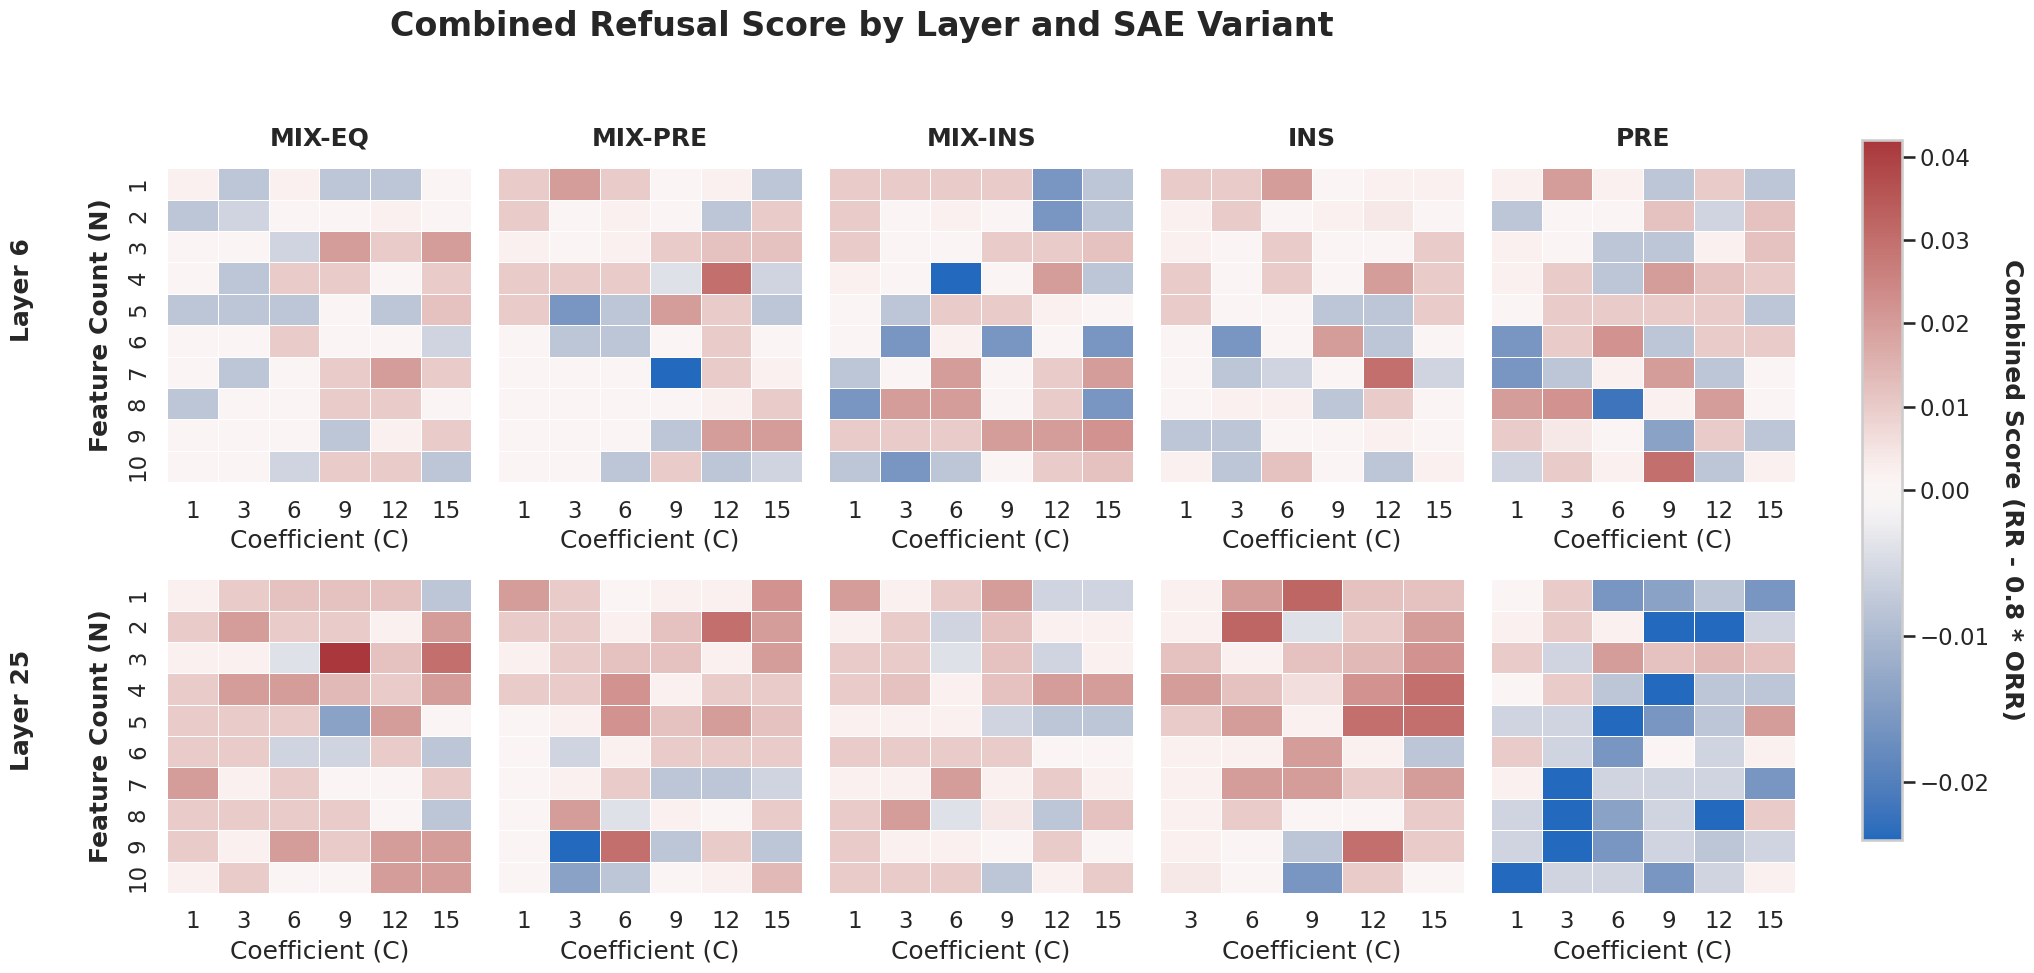

✅ Plot saved to results/visualizations/combined_feature_score_heatmaps.png


In [22]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import matplotlib.colors as mcolors
import numpy as np
import json

def plot_combined_score_heatmaps(df, results_path="results/visualizations",
                                 filename="combined_feature_score_heatmaps.png"):
    """
    Plots a 2x4 grid of heatmaps using a custom discrete colormap with an
    explicit neutral bin for zero and perfectly centered ticks.
    """
    df = df.copy()

    # 1. Prepare the DataFrame
    df['variant'] = df['model'].apply(simplify_name)
    df['layer'] = df['hookpoint'].str.split('.').str[1].astype(int)
    df['score'] = df['rr'] - 0.8 * df['orr']

    try:
        config_path = "evaluation/feature_grid_configs_135M.json"
        with open(config_path, 'r') as f:
            full_configs = json.load(f)
        
        # Create a mapping from the result path to the feature indices
        indices_map = {item['out_path']: item['feature_indices'] for item in full_configs}
        
        # Add the 'feature_indices' column to the DataFrame
        df['feature_indices'] = df['result_path'].map(indices_map)
        # Handle cases where a result might not be in the original config
        df['feature_indices'].fillna("Not Found", inplace=True)
        
    except FileNotFoundError:
        print(f"⚠️  Warning: Config file not found at {config_path}. Cannot display feature indices.")
        df['feature_indices'] = [['N/A']] * len(df)

    # hotfix: 
    df.loc[(df['variant'] == 'PRE') & (df['layer'] == 24), 'layer'] = 25
    variants = ["MIX-EQ", "MIX-PRE", "MIX-INS", "INS", "PRE"]
    layers = [6, 25]

    # 2. Set up the plot theme and layout
    sns.set_theme(style="whitegrid", context="talk")
    fig, axes = plt.subplots(nrows=len(layers), ncols=len(variants), figsize=(20, 10), sharey=True)

    # 3. Create a custom colormap and boundaries
    vmin_data = df['score'].min()
    vmax_data = df['score'].max()

    norm = mcolors.TwoSlopeNorm(vcenter=0, vmin=vmin_data, vmax=vmax_data)
    # Use a continuous diverging colormap
    cmap = 'vlag'

    # 4. Draw each heatmap
    for i, layer in enumerate(layers):
        for j, variant in enumerate(variants):
            ax = axes[i, j]
            subset = df[(df['layer'] == layer) & (df['variant'] == variant)]

            if subset.empty:
                ax.text(0.5, 0.5, "No Data", ha="center", va="center", transform=ax.transAxes)
                ax.set_xticks([]); ax.set_yticks([]); continue

            pivot_table = subset.pivot_table(index='N', columns='C', values='score', aggfunc='mean').fillna(0)

            sns.heatmap(
                pivot_table, ax=ax, cmap=cmap, norm=norm,
                cbar=False, linewidths=0.5, linecolor="white"
            )

            if i == 0:
                ax.set_title(variant, pad=16, fontweight="bold")
            ax.set_xlabel("Coefficient (C)")
            if j == 0:
                ax.set_ylabel("Feature Count (N)", labelpad=10, fontweight="bold")
            else:
                ax.set_ylabel("")

    # 5. Add shared colorbar with perfectly centered ticks
    cbar_ax = fig.add_axes([1.0, 0.15, 0.02, 0.7])
    mappable = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    cbar = fig.colorbar(mappable, cax=cbar_ax)
    cbar.set_label('Combined Score (RR - 0.8 * ORR)', rotation=270, labelpad=25, fontweight="bold")
    
    # 6. Add row labels
    for i, layer in enumerate(layers):
        fig.text(0.08, 0.70 - i*0.42, f"Layer {layer}", ha='center', va='center', rotation='vertical',
                 fontsize=18, fontweight='bold')

    # 7. Final adjustments and title
    fig.suptitle("Combined Refusal Score by Layer and SAE Variant", fontsize=24, fontweight="bold", y=0.98)
    fig.tight_layout(rect=[0.1, 0, 0.98, 0.95])

    
    # -------------------------------------------- #
    print("\n" + "="*80)
    print("Top-5 Feature Indices by Combined Score")
    print("="*80)
    
    # This check ensures the code doesn't crash if the column is missing.
    if 'feature_indices' not in df.columns:
        print("\nATT! 'feature_indices' column not found in DataFrame. Skipping top-5 analysis.")
        # Add a placeholder column to prevent errors in the loop
        df['feature_indices'] = [['N/A']] * len(df) 
    
    for variant in variants:
        for layer in layers:
            print(f"\n--- Variant: {variant}, Layer: {layer} ---")
            
            # Filter the DataFrame for the current group
            group_df = df[(df['variant'] == variant) & (df['layer'] == layer)]
            
            if group_df.empty:
                print("  No data available.")
                continue

            # Find the top 5 entries with the highest score
            # Note: This assumes one feature index per row. If N>1, this finds the top rows.
            top_5 = group_df.nlargest(5, 'score')
            
            if top_5.empty:
                print("  No entries with a score found.")
                continue

            # Print the details for each of the top 5
            for _, row in top_5.iterrows():
                # The 'C' column is also useful context
                c_val = row.get('C', 'N/A')
                print(
                    f"  Score: {row['score']:.4f} | "
                    f"RR: {row['rr']:.3f}, ORR: {row['orr']:.3f} | "
                    f"C={c_val} | "
                    f"Indices: {row['feature_indices']}"
                )
    # -------------------------------------------- #
    
    output_dir = Path(results_path)
    output_dir.mkdir(parents=True, exist_ok=True)
    out_file = output_dir / filename
    
    plt.savefig(out_file, dpi=150, bbox_inches="tight")
    plt.show()
    plt.close(fig)
    print(f"✅ Plot saved to {out_file}")
    
# Example of how to call the function with your DataFrame `df`
plot_combined_score_heatmaps(df)